# Generate a PPi train + validation set from [APID](http://cicblade.dep.usal.es:8080/APID/init.action) and a Y2H test set from [HuRI](http://www.interactome-atlas.org/download)
## prep

- March 2021 version of [APID](http://cicblade.dep.usal.es:8080/APID/init.action)
- interactomes for the 35 organisms listed as "with more than 500 interactions" only
- some organism datasets will be dropped later, so not fetching smaller sets is ok
- binary interactomes -> Level 2 -> `Q1` suffix
- not using *H. sapiens* for training -> `9606_*Q1.txt`


first number is number of IDs, second is number of PPIs

| APID     |              ISI |            noISI |      loss |
|---------:|:----------------:|:----------------:|:---------:|
| w/ Human | 67'240 : 319'429 | 61'429 : 296'653 | .09 : .07 |
| no Human | 55'014 : 179'349 | 45'026 : 161'598 | .18 : .10 |
|     loss |    .18 : .44     |    .27 : .46     | .33 : .49 |

In [357]:
from __future__ import annotations

import os
import sys
import shutil
import importlib

import numpy as np
from tqdm import tqdm
from pathlib import Path
from dataclasses import dataclass, field

import pandas as pd
from dataclass_wizard import JSONWizard

In [2]:
!which python
!pwd

/home/quirin/anaconda3/envs/ppi/bin/python
/home/quirin/PYTHON/ppi/data/ppi_dataset/template


In [3]:
# assert False, 'don\'t run'
# !mv apid.zip ../apid.zip
# !mv hi_union.psi ../hi_union.psi
# !ln ../apid.zip apid.zip
# !ln ../hi_union.psi hi_union.psi

In [4]:
cwd = Path.cwd()
package_root = str(cwd.parents[2])
if package_root not in sys.path:
    sys.path.append(package_root)

In [7]:
session = '7062'
session_dir = cwd.parent / 'results' / session

if not session_dir.is_dir():
    shutil.copytree(cwd, session_dir,
                    symlinks=True, dirs_exist_ok=True)
os.chdir(session_dir.resolve())
!pwd

/home/quirin/PYTHON/ppi/data/ppi_dataset/results/7062


In [358]:
from data.utils import api, extract, general, pairs, plot, reduce, proteome

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *
from data.utils.proteome import *

#### config

In [9]:

@dataclass
class Config(JSONWizard):
    class _(JSONWizard.Meta):
        key_transform_with_dump = 'SNAKE'

    keep_human: bool = False
    keep_interspecies: bool = False
    accept_homodimers: bool = False
    remote_rostclust: bool = True
    add_proteomes: bool = True

    ap: Path = Path('apid')
    hp: Path = Path('huri')
    qp: Path = None
    pp: Path = Path('swissprot')

    min_seq_len: int = 50
    max_seq_len: int = 1500

    psi_path = Path('hi_union.psi')
    hval_config: dict = field(default_factory=dict)
    hval_config_path: Path = Path('hval_config.json')

    seed: int = 42
    ratio: float = 10.0
    strategy: SamplingStrategy = SamplingStrategy.BALANCED

    val_set_size: float = .1
    val_species: Set[str] = field(default_factory=set)
    train_species: Set[str] = field(default_factory=set)

    val_raw_fasta: Path = ap / 'apid_validation_raw.fasta'
    val_raw_tsv: Path = ap / 'apid_validation_raw.tsv'
    val_rr_fasta: Path = ap / 'apid_validation_rr.fasta'
    val_rr_tsv: Path = ap / 'apid_validation_rr.tsv'
    val_sp_fasta: Path = ap / 'apid_validation_sp.fasta'
    val_sp_tsv: Path = ap / 'apid_validation_sp.tsv'
    val_c3_fasta: Path = ap / 'apid_validation_c3.fasta'
    val_fasta: Path = Path('apid_validation.fasta')
    val_tsv: Path = Path('apid_validation.tsv')

    test_raw_fasta: Path = hp / 'huri_test_raw.fasta'
    test_raw_tsv: Path = hp / 'huri_test_raw.tsv'
    test_rr_fasta: Path = hp / 'huri_test_rr.fasta'
    test_rr_tsv: Path = hp / 'huri_test_rr.tsv'
    test_sp_fasta: Path = hp / 'huri_test_sp.fasta'
    test_sp_tsv: Path = hp / 'huri_test_sp.tsv'
    test_c3_fasta: Path = hp / 'huri_test_c3.fasta'
    test_fasta: Path = Path('huri_test.fasta')
    test_tsv: Path = Path('huri_test.tsv')

    train_tsv: Path = Path('apid_train.tsv')
    train_fasta: Path = Path('apid_train.fasta')
    train_raw_fasta: Path = ap / 'apid_train_raw.fasta'
    train_raw_tsv: Path = ap / 'apid_train_raw.tsv'

    train_proteome: Path = Path('train_proteome.json')
    val_proteome: Path = Path('val_proteome.json')
    test_proteome: Path = Path('test_proteome.json')

    # results
    weird_species: set[int] = field(default_factory=set)
    train_bias: str = None
    train_seqs: int = None
    train_extra: int = None
    train_size: int = None
    test_seqs: int = None
    test_extra: int = None
    val_seqs: int = None
    val_extra: int = None
    val_bias: str = None
    val_size: int = None
    val_sizes: str = None
    test_bias: float = None
    test_size: int = None
    test_sizes: str = None


val_species = {10377, 37296, 9031, 8355, 9913, 7955,
               39947, 10116} | {36329, 10299, 237561}
hval_config = dict(shortAlignmentLen=50,
                   longSeqLen=180,
                   reduceRandomAlign=False,
                   clusterThreshold=20)

c = Config(hval_config=hval_config, val_species=val_species)

In [10]:
remote = Path('/home/k/kaindll') / Path(*session_dir.parts[4:])


def push():
    if c.remote_rostclust:
        !rsync -zar --size-only -e ssh "." "kaindll@lapislazuli:{remote}"


def pull():
    if c.remote_rostclust:
        !rsync -zar --size-only -e ssh "kaindll@lapislazuli:{remote}/" "."


c.remote_rostclust, remote

(True, PosixPath('/home/k/kaindll/ppi/data/ppi_dataset/results/7062'))

#### `importlib`

In [11]:
importlib.reload(api)
importlib.reload(extract)
importlib.reload(general)
importlib.reload(pairs)
importlib.reload(plot)
importlib.reload(reduce)
importlib.reload(proteome)

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *
from data.utils.proteome import *

## Toy example
#### bias of negative dataset

In [10]:
# demonstrate sampling strategies: toy PPI table example
raw = '''A\tB\nA\tC\nC\tF\nA\tE\nK\tL\nC\tK\nB\tG\nG\tM\nA\tO\nE\tO\nI\tJ\nJ\tK\nI\tK'''
ppis = ppis_from_string(raw)
ppi_dict = dict()
ppis

,0,1
0,A,B
1,A,C
2,C,F
3,A,E
4,K,L
5,C,K
6,B,G
7,G,M
8,A,O
9,E,O


In [11]:
ppi_dict['balanced'], *_ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                               strategy=SamplingStrategy.BALANCED)
# balanced sampling tries to conserve the distribution of degrees -> high-bias dataset

40it [00:00, 5910.59it/s]             


In [12]:
ppi_dict['random'], *_ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                             strategy=SamplingStrategy.RANDOM)
# random sampling gives a nearly un-biased dataset

40it [00:00, 5253.06it/s]             


In [13]:
ppi_dict['complement'], *_ = find_negative_pairs(ppis, ratio=10, seed=42,
                                                 strategy=SamplingStrategy.BALANCED)
# sampling the entire network complement will perfectly invert the degree distribution

390it [00:00, 5447.82it/s]             


#### strategies visualized
It becomes apparent that the combination of graph size and density is important, and that random or balanced sampling generate different sets of negatives.

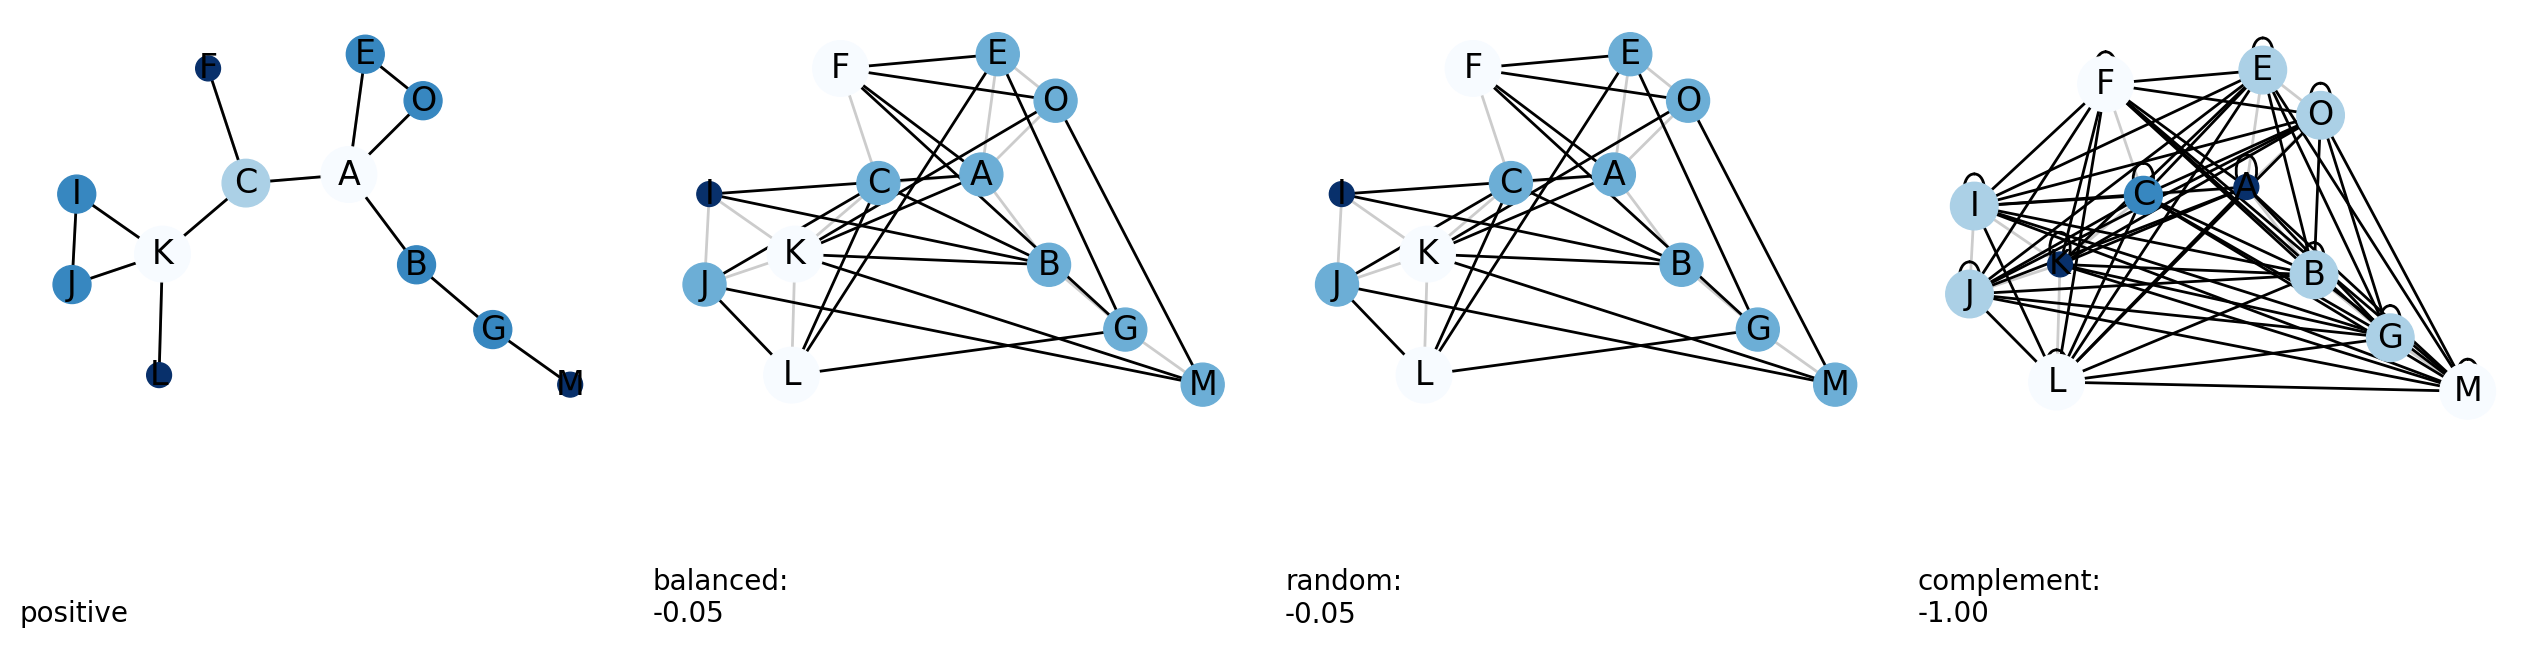

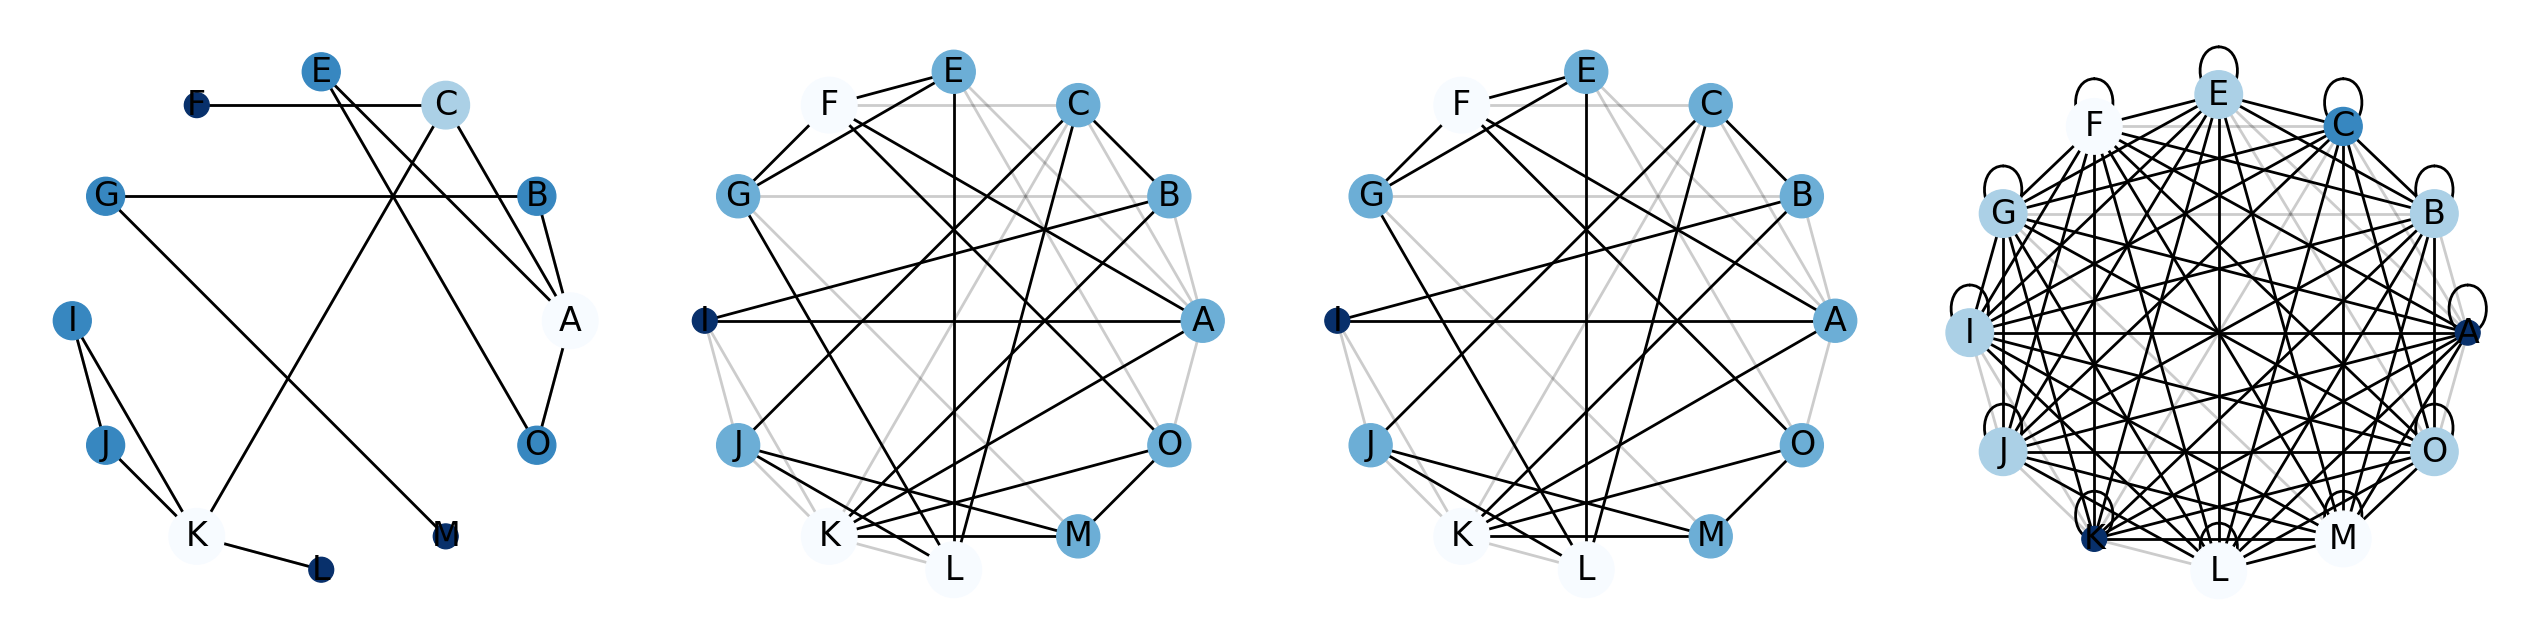

In [14]:
_ = draw_toy_ppis(ppis, ppi_dict)

#### with homodimers

In [15]:
# added F-F
raw = '''A\tB\nA\tC\nC\tF\nA\tE\nK\tL\nC\tK\nB\tG\nG\tM\nA\tO\nE\tO\nI\tJ\nJ\tK\nI\tK\nF\tF'''
ppis = ppis_from_string(raw)

100%|██████████| 42/42 [00:00<00:00, 5755.38it/s]
432it [00:00, 10472.73it/s]            


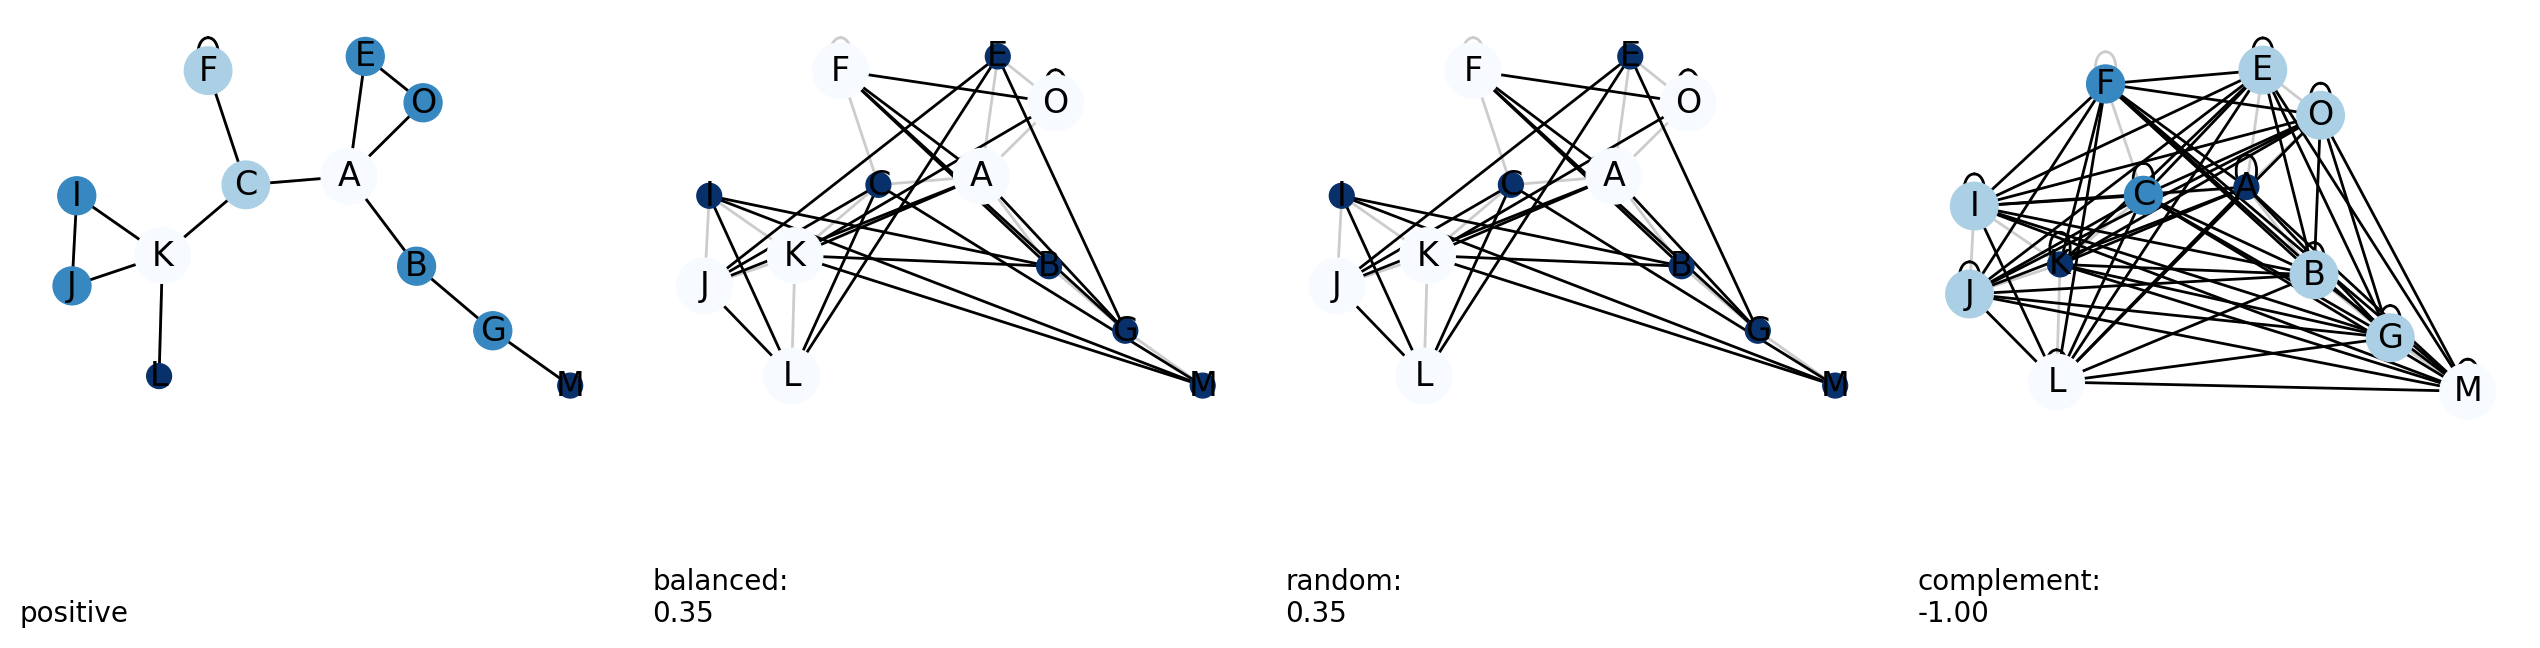

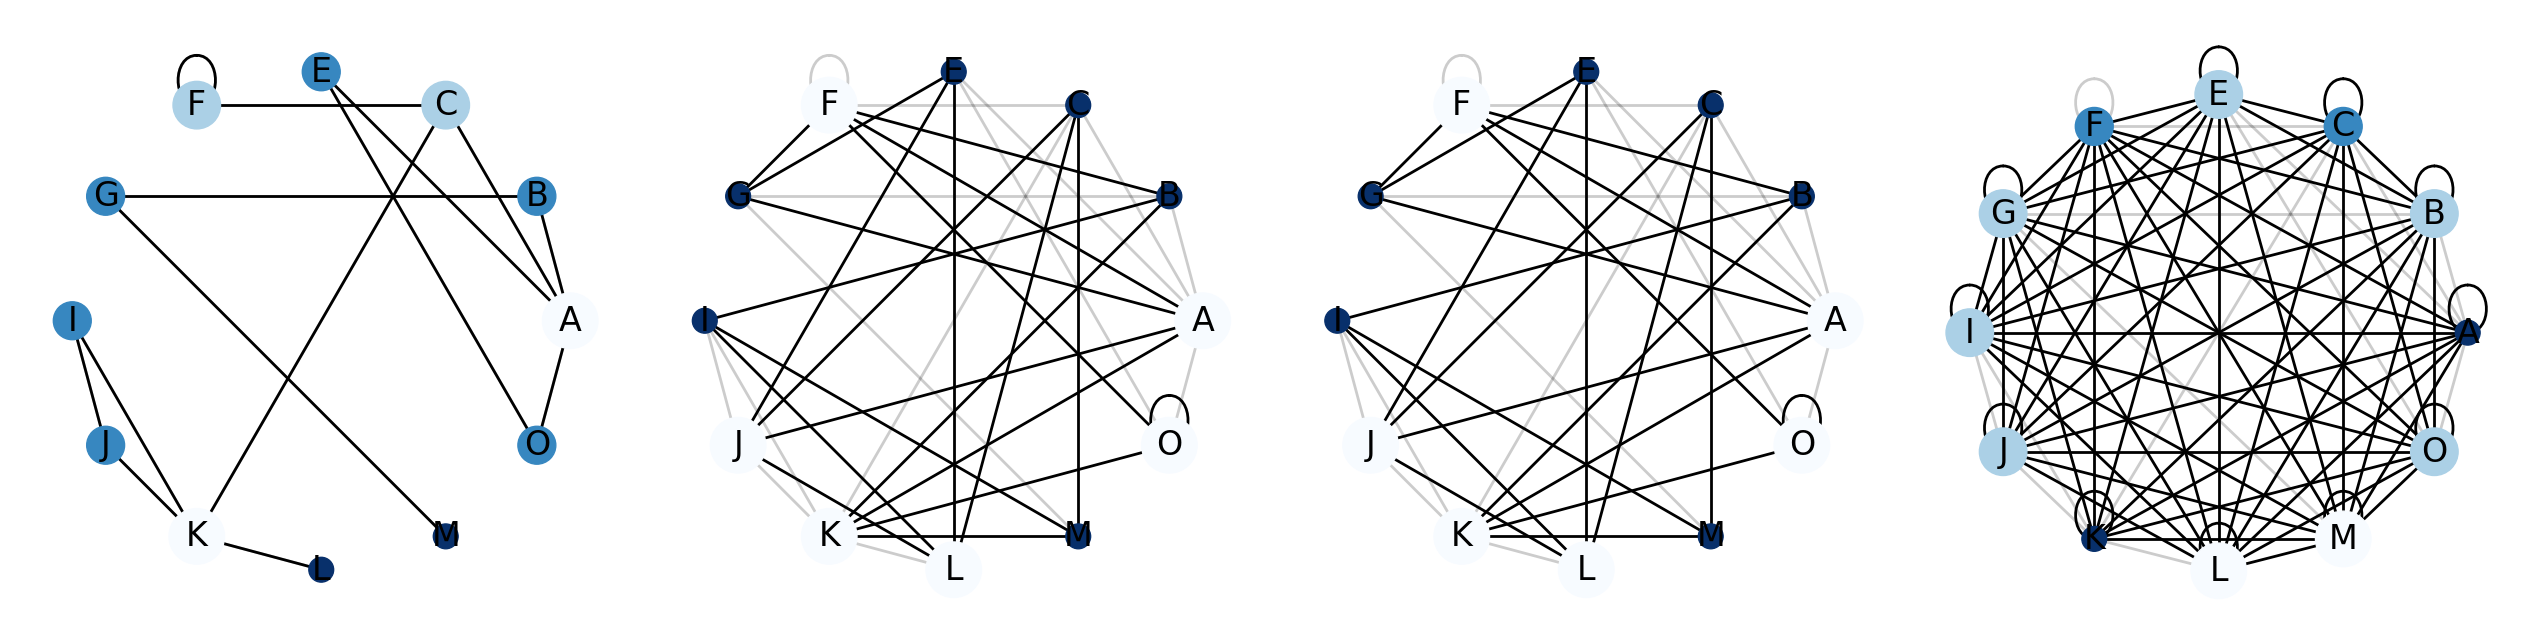

In [16]:
ppi_dict = dict()
ppi_dict['balanced'], *_ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                               strategy=SamplingStrategy.BALANCED)
ppi_dict['random'], *_ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                             strategy=SamplingStrategy.RANDOM)
ppi_dict['complement'], *_ = find_negative_pairs(ppis, ratio=10, seed=42,
                                                 strategy=SamplingStrategy.BALANCED)
_ = draw_toy_ppis(ppis, ppi_dict)

#### input homodimers, but not allowed as negatives

100%|██████████| 42/42 [00:00<00:00, 6845.71it/s]
454it [00:00, 9781.85it/s]             


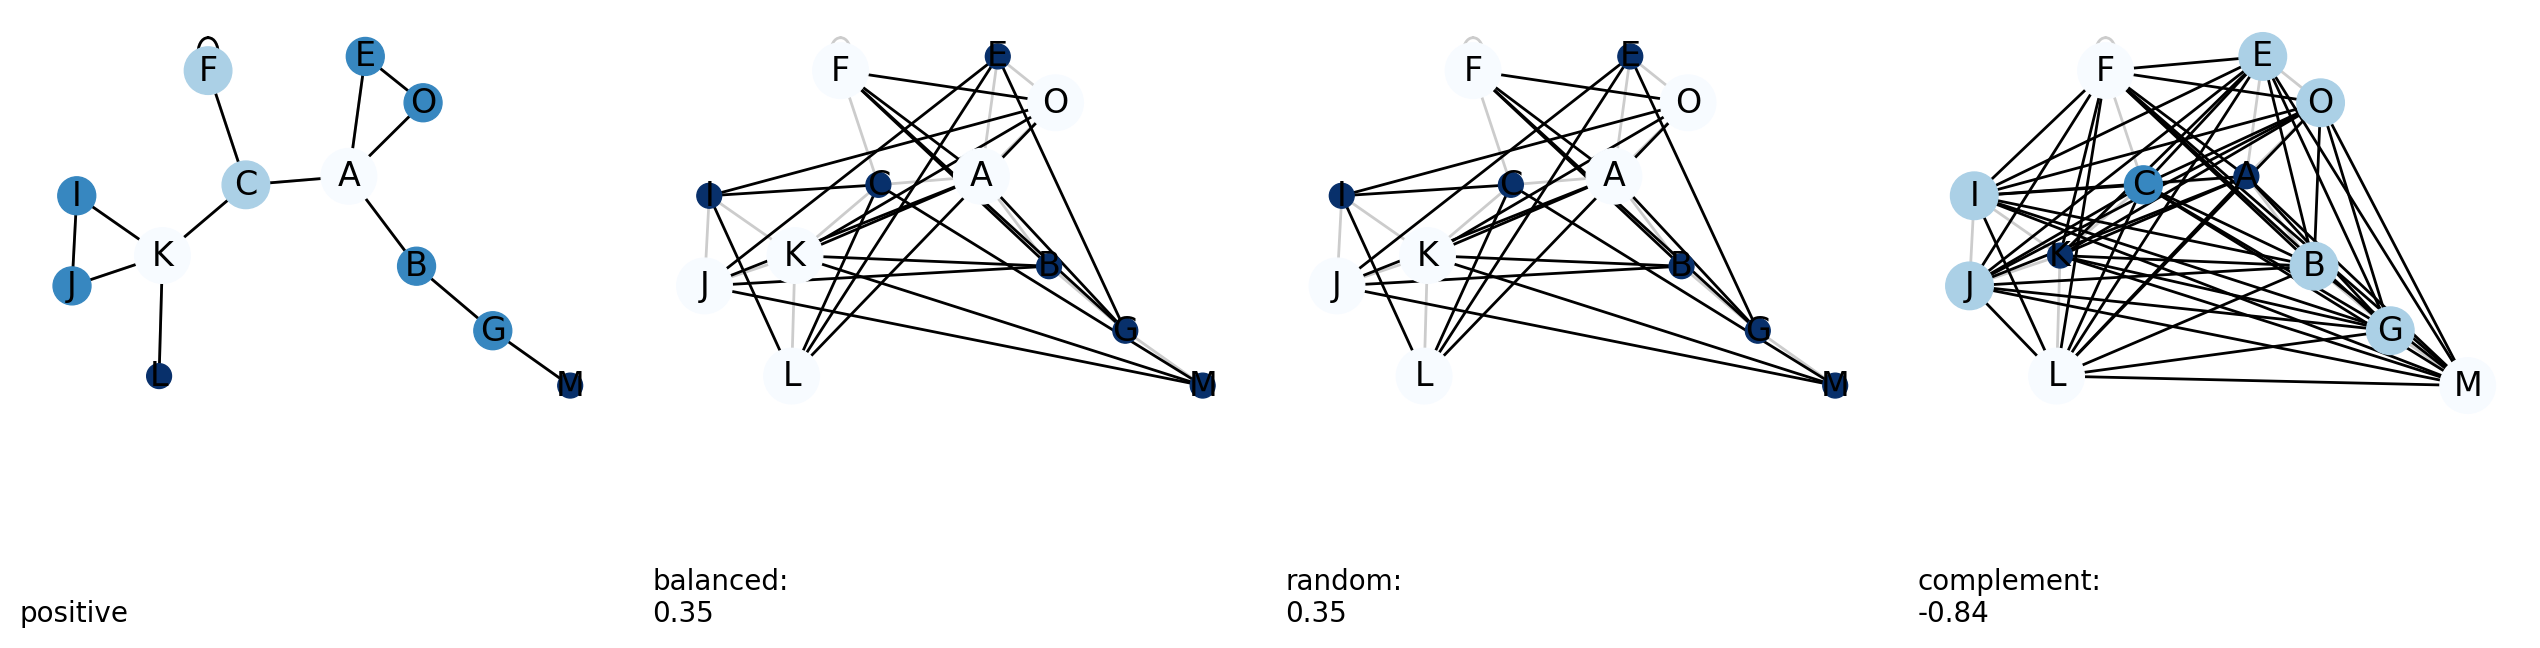

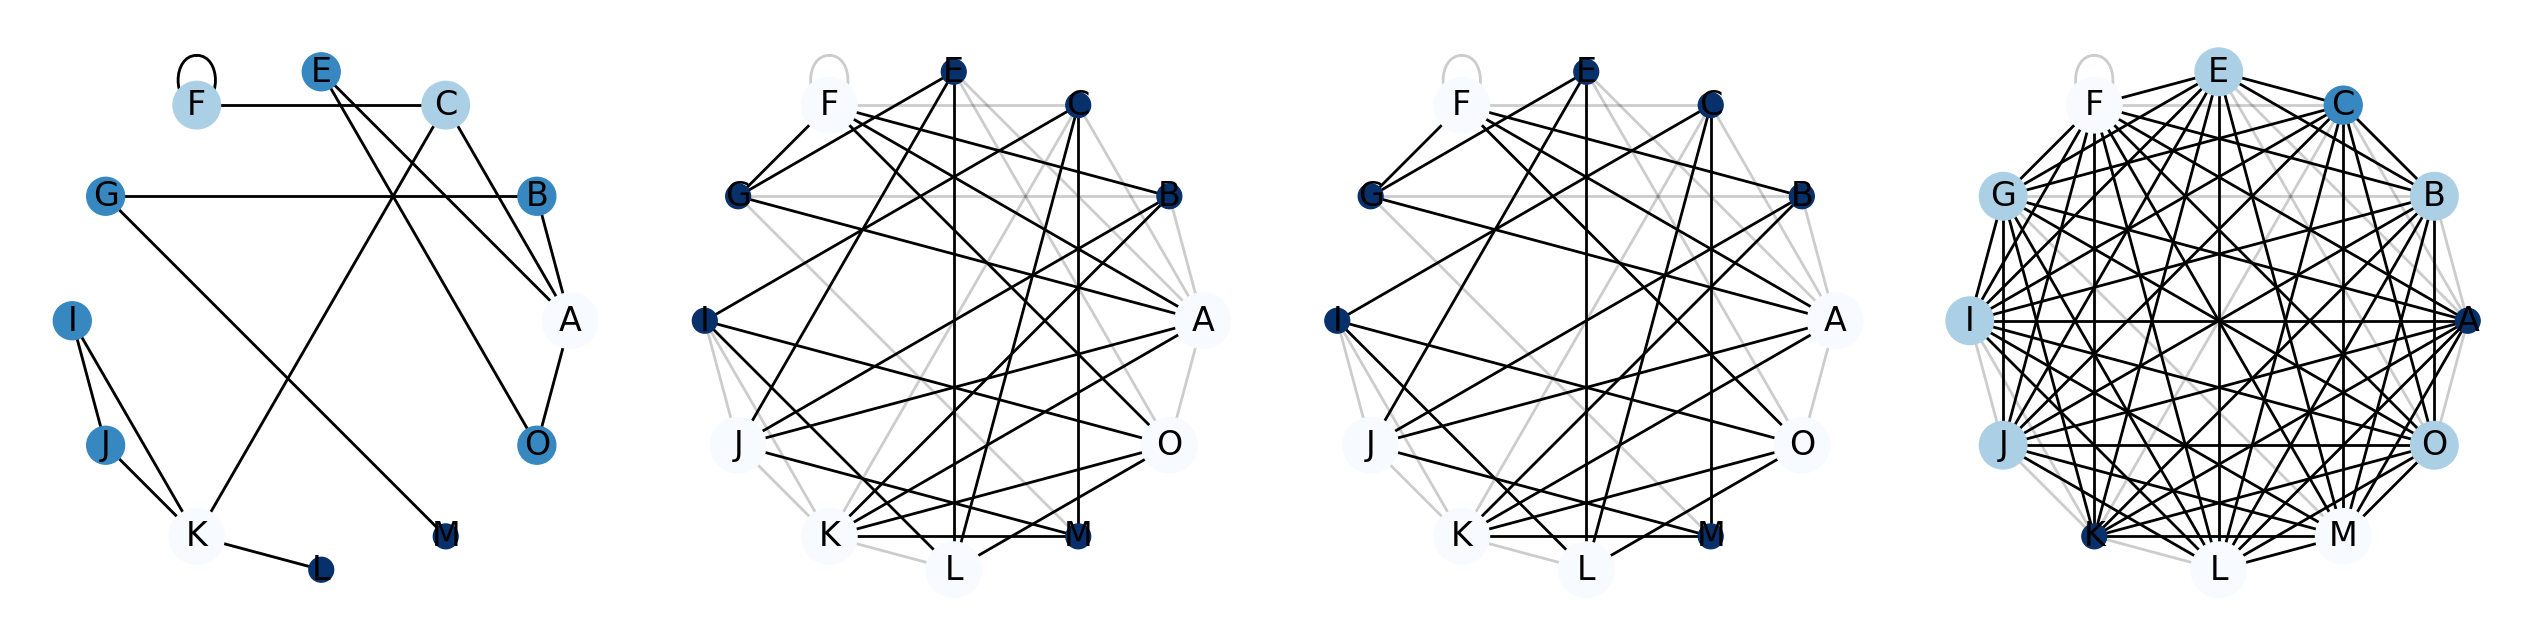

In [17]:
ppi_dict = dict()
ppi_dict['balanced'], *_ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                               strategy=SamplingStrategy.BALANCED,
                                               accept_homodimers=False)
ppi_dict['random'], *_ = find_negative_pairs(ppis, ratio=1.5, seed=42,
                                             strategy=SamplingStrategy.RANDOM,
                                             accept_homodimers=False)
ppi_dict['complement'], *_ = find_negative_pairs(ppis, ratio=10, seed=42,
                                                 strategy=SamplingStrategy.BALANCED,
                                                 accept_homodimers=False)
_ = draw_toy_ppis(ppis, ppi_dict)

## Train set: APID
#### extract from `<taxid>*_Q1.txt` files

In [12]:
c.qp = unzip_apid(zip_path='apid.zip', keep_human=c.keep_human,
                  keep_interspecies=c.keep_interspecies)
c.qp

PosixPath('apid_q1')

In [13]:
uniprot_ids = extract_apid_uniprot_ids(c.qp)
len(uniprot_ids)

45026

In [14]:
ppis = extract_apid_ppis(c.qp)
len(ppis)

161598

In [15]:
ppis.head()

,UniprotID_A,UniprotID_B,species
0,O40944,Q98131,37296
1,D2XQF2,Q77GV9,37296
2,O40917,Q98143,37296
3,O40917,Q76RG7,37296
4,O40917,Q76RG4,37296


#### interspecies interactions
Check if there are PPIs (based on UniProt IDs) that occur in several species. We use APID `noISI` data per default, so the exclusion of this data is not implemented.

In [16]:
find_multi_species_ppis = lambda ppi_df: pd.concat(
    [df for i, df in ppi_df.groupby(
        ['UniprotID_A', 'UniprotID_B']) if len(df) > 1]
    + [ppi_df.loc[ppi_df.species == 'is there a marsupilami?']])

find_multi_species_ppis(ppis)

,UniprotID_A,UniprotID_B,species


In [17]:
# proof that actually worked: add some dummy data
for i in [0, 1]:
    s = ppis.iloc[i].copy()
    s.species = 'marsupilami'
    ppis = pd.concat([ppis, pd.DataFrame(s).T], axis=0)

marsu = find_multi_species_ppis(ppis)

# drop the dummy data
ppis = ppis.loc[ppis.species != 'marsupilami']
marsu

,UniprotID_A,UniprotID_B,species
1,D2XQF2,Q77GV9,37296
1,D2XQF2,Q77GV9,marsupilami
0,O40944,Q98131,37296
0,O40944,Q98131,marsupilami


or more generally protein IDs that occur in several species:

In [18]:
find_multi_species_proteins(ppis)

,UniprotID,species


#### download sequences

In [20]:
# # skip if re-running this w/o changes above or deleting files
# _ = uniprot_api_fetch(uniprot_ids, c.ap / 'apid')

#### download proteomes

In [21]:
# # skip if re-running this w/o changes above or deleting files
# if c.add_proteomes:
#     fetch_proteomes(set(taxonomy.species) | {9606}, c.pp)

#### map IDs to seq hashes

In [29]:
hash_ppis = ppis_to_hashes(ppis, c.ap / 'apid.json').drop_duplicates()
hash_ppis.head()

,hash_A,hash_B,species
3,CRC-48F409F4E28F37BE,CRC-9AC87796A0BA67D9,632
1,CRC-4A7DEB955583CB27,CRC-6D6C1B4ED5C94EC7,632
0,CRC-5E21543540EBF92B,CRC-8561A9A0C1A2E169,632
2,CRC-8049DCC1A80C7391,CRC-9AC87796A0BA67D9,632
4,CRC-9AC87796A0BA67D9,CRC-9AC87796A0BA67D9,632


In [30]:
len(ppis) - len(hash_ppis)

1030

In [31]:
fasta = SeqIO.to_dict(SeqIO.parse(c.ap / 'apid.hash.fasta', 'fasta'))
len(fasta)

44707

#### filter by seq length

In [32]:
c.min_seq_len, c.max_seq_len

(50, 1500)

dropped 9425/160568 PPIs from length filtering
dropped 0/42505 table IDs and 0/151143 rows, and 2202/44707 sequence IDs


(44707, 42505)

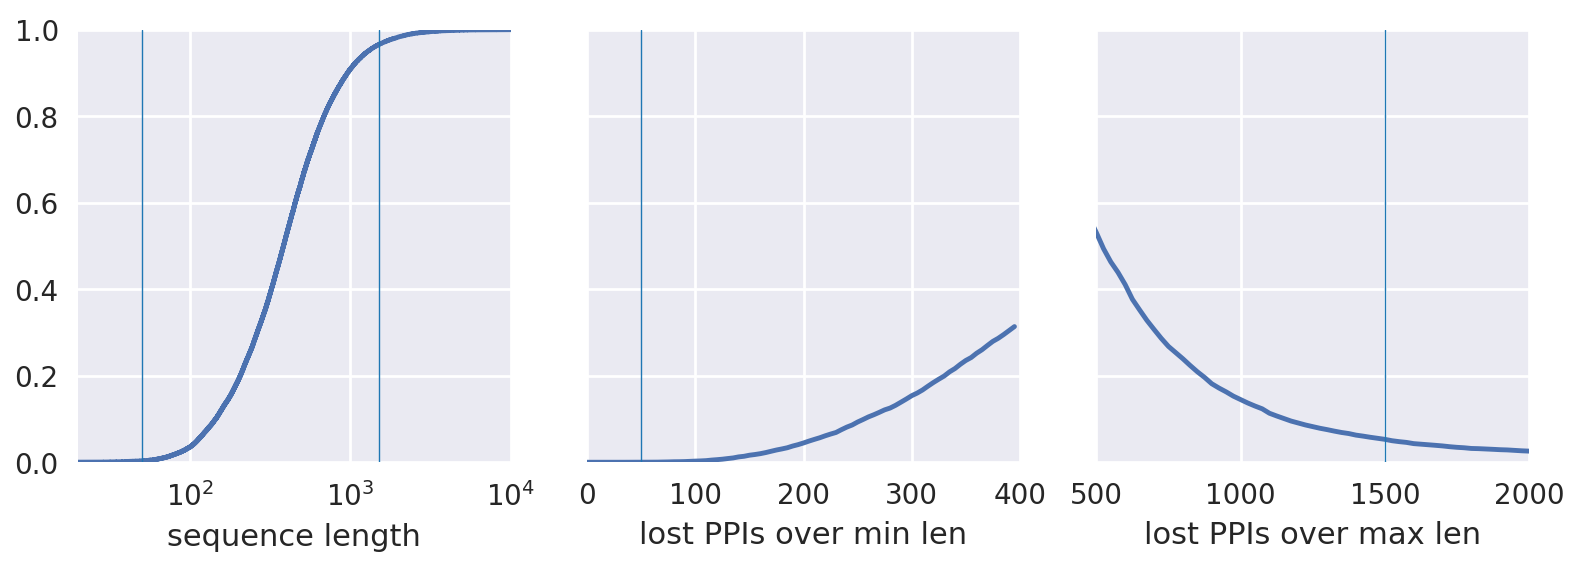

In [33]:
_hash_ppis, _fasta, fig = filter_ppis_and_fasta_by_len(
    hash_ppis, fasta, c.min_seq_len, c.max_seq_len)
len(fasta), len(_fasta)

continue if these limits were ok, or change/set the values for
`cfg.min_seq_len, cfg.max_seq_len` and re-run the filtering cell

In [34]:
hash_ppis = _hash_ppis
fasta = _fasta

In [35]:
# # skip if re-running this w/o changes above or deleting files
# if c.add_proteomes:
#     filter_proteomes_by_len(c.pp, c.min_seq_len, c.max_seq_len)

#### homodimer share
Overall count, share, overall PPI count

(False, 4249, 0.0281, 151143)

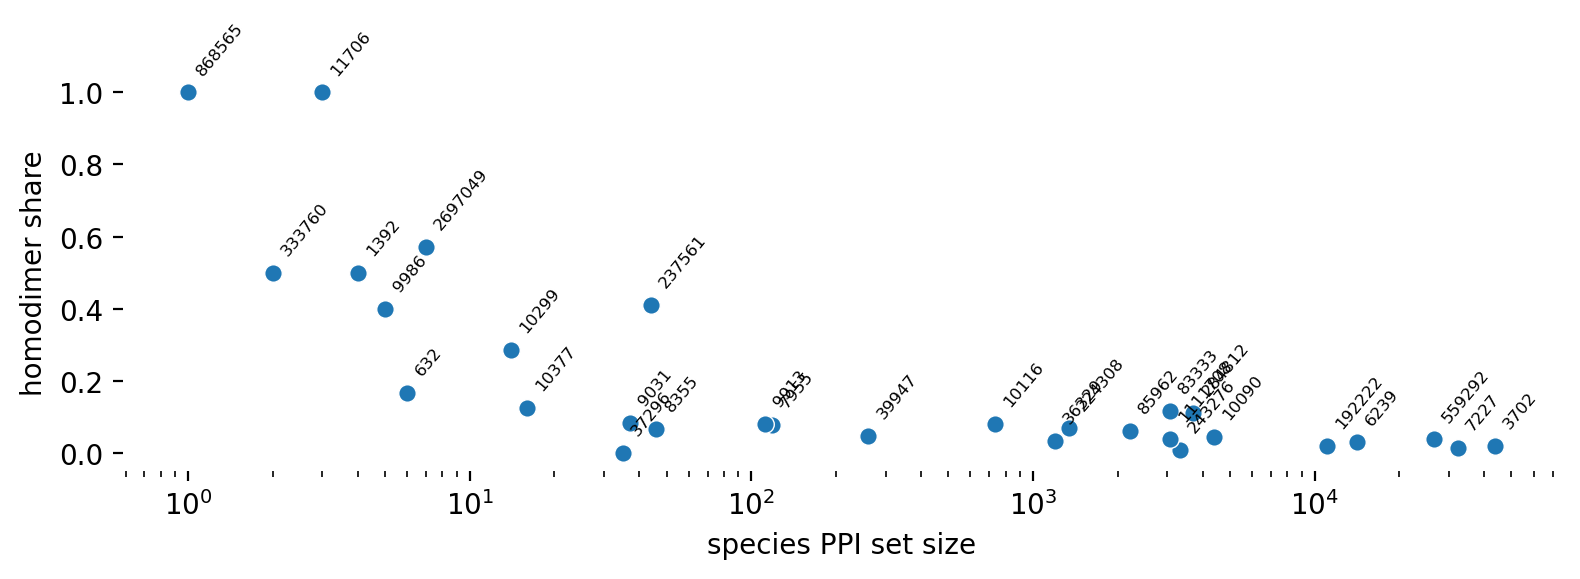

In [36]:
_ = plot_homodimer_share(hash_ppis)
c.accept_homodimers, *count_homodimers(hash_ppis),

In [37]:
if not c.accept_homodimers:
    hash_ppis = drop_homodimers(hash_ppis)
    hash_ppis, fasta = shrink_both_ways(hash_ppis, fasta)
len(hash_ppis), len(fasta)

dropped 0/42053 table IDs and 0/146894 rows, and 452/42505 sequence IDs


(146894, 42053)

#### species lookup

In [451]:
# pick not just viruses for validation!
taxonomy = fetch_taxonomic_info(hash_ppis.species)
taxonomy

100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


,species,name,n_ppis
0,632,Yersinia pestis,5
1,1392,Bacillus anthracis,2
2,3702,Arabidopsis thaliana,42794
3,6239,Caenorhabditis elegans,13694
4,7227,Drosophila melanogaster,31832
5,7955,Danio rerio,109
6,8355,Xenopus laevis,43
7,9031,Gallus gallus,34
8,9913,Bos taurus,103
9,9986,Oryctolagus cuniculus,3


In [472]:
taxonomy.sort_values(by='n_ppis')

,species,name,n_ppis
24,333760,Human papillomavirus type 16,1
1,1392,Bacillus anthracis,2
27,2697049,Severe acute respiratory syndrome coronavirus 2,3
9,9986,Oryctolagus cuniculus,3
0,632,Yersinia pestis,5
12,10299,Human alphaherpesvirus 1 strain 17,10
13,10377,Human herpesvirus 4 strain B95-8,14
21,237561,Candida albicans SC5314,26
7,9031,Gallus gallus,34
15,37296,Human gammaherpesvirus 8,35


In [473]:
print(taxonomy.loc[taxonomy.species.isin({10090, 83333})].sort_values(by='n_ppis').to_markdown(index=False))

|   species | name                  |   n_ppis |
|----------:|:----------------------|---------:|
|     83333 | Escherichia coli K-12 |     2707 |
|     10090 | Mus musculus          |     4186 |


## Validation set: APID
#### val: select species/proteins
Either by sampling a subset of proteins and selecting the PPIs or picking the ones for one or more particular species

In [38]:
c.val_set_size, c.val_species

(0.1, {7955, 8355, 9031, 9913, 10116, 10377, 37296, 39947})

In [439]:
taxonomy.loc[taxonomy.species.isin(c.val_species)]

,species,name,n_ppis
12,10299,Human alphaherpesvirus 1 strain 17,16
15,36329,Plasmodium falciparum 3D7,2728
22,237561,Candida albicans SC5314,44


In [39]:
hash_ppis['label'] = 1
if c.val_species is not None:
    train, val = make_validation_species(hash_ppis, c.val_species)
else:
    # if the set becomes too large, try another seed!
    # With this approach, PPIs *will* be lost
    train, val = make_validation_split(hash_ppis, c.val_set_size, c.seed)
    c.val_species = set(val.species)
c.train_species = set(train.species)
len(train), len(train) / len(hash_ppis), len(val), len(val) / len(hash_ppis)

(145635, 0.9914291938404564, 1151, 0.00783558212044059)

In [40]:
val.head()

,hash_A,hash_B,species,minlen,maxlen,label
122,CRC-000BC5DD420D0669,CRC-2808F51BBD3A8B6E,7955,264,363,1
19,CRC-0B5D3548EEF911AE,CRC-F5A8EAFC27AD733E,7955,574,940,1
65,CRC-0E6AE7E0F9C5520F,CRC-3C5E4EDDF27EACFF,7955,424,999,1
20,CRC-12077214EFED46D0,CRC-F5A8EAFC27AD733E,7955,558,940,1
85,CRC-12A7DE26809AAAF4,CRC-DAB541D403215A02,7955,169,1030,1


In [41]:
val.species.unique(), train.species.unique()

(array([ 7955,  8355,  9031,  9913, 10116, 10377, 37296, 39947]),
 array([    632,    1392,    3702,    6239,    7227,    9986,   10090,
          10299,   36329,   83333,   85962,  192222,  224308,  237561,
         243276,  284812,  333760,  559292, 1111708, 2697049]))

Separate the validation set sequences from the ones remaining as train set

#### train: save seqs + positives


In [42]:
_, train_seqs = shrink_both_ways(train.copy(), fasta.copy())
c.train_seqs = len(train_seqs)
len(train_seqs), len(fasta)

dropped 0/40833 table IDs and 0/145635 rows, and 1220/42053 sequence IDs


(40833, 42053)

In [43]:
_ = SeqIO.write(values_sorted_by_key(train_seqs), c.train_raw_fasta, 'fasta')
train.to_csv(c.train_raw_tsv, sep='\t', header=True, index=False)
c.train_raw_fasta, c.train_raw_tsv

(PosixPath('apid/apid_train_raw.fasta'), PosixPath('apid/apid_train_raw.tsv'))

#### val: save seqs + positives

In [44]:
_, val_seqs = shrink_both_ways(val.copy(), fasta.copy())
len(val_seqs), len(fasta)

dropped 0/1197 table IDs and 0/1151 rows, and 40856/42053 sequence IDs


(1197, 42053)

In [45]:
_ = SeqIO.write(values_sorted_by_key(val_seqs), c.val_raw_fasta, 'fasta')
val.to_csv(c.val_raw_tsv, sep='\t', header=True, index=False)
c.val_raw_fasta, c.val_raw_tsv

(PosixPath('apid/apid_validation_raw.fasta'),
 PosixPath('apid/apid_validation_raw.tsv'))

Mind that the TSVs will contain only positives! Sample negatives only after most of the `uniqueprot`-shebang.

## Test set: HuRI
#### download and extract PPIs

In [46]:
c.psi_path

PosixPath('hi_union.psi')

In [47]:
# it's somehow a lot faster to download this from a browser!
# or run !wget "http://www.interactome-atlas.org/data/HI-union.psi" -O "hi_union.psi"
download_y2h_interactome(c.psi_path)

already downloaded and SHA256 checks out


PosixPath('hi_union.psi')

In [48]:
huri_ppis, huri_seq_ids = extract_huri_ppis(c.psi_path)
len(huri_ppis)

97888

In [50]:
huri_seqs, _ = fetch_huri_seqs(huri_seq_ids, c.hp / 'huri')
len(huri_seqs)

loading from huri/huri.fasta and huri/huri.json


9119

#### map + filter PPIs

In [51]:
print(set(huri_ppis.species))  # only human, but keep the label
huri_ppis.head()

{9606}


,0,1,species
0,P0DP25,A0A087WXN0,9606
1,Q68D86-1,Q9HD26-2,9606
2,Q13515,Q9UJW9,9606
3,P30049,Q05519-2,9606
4,ENSP00000462298,P43220,9606


In [52]:
# some 35K protein IDs point to the same sequence
huri_hash_ppis = ppis_to_hashes(huri_ppis, c.hp / 'huri.json')
len(huri_ppis), len(huri_ppis) - len(huri_hash_ppis), len(huri_hash_ppis)

(97888, 35329, 62559)

In [53]:
huri_hash_ppis.head()

,hash_A,hash_B,species
22905,CRC-000037AE195F7A9D,CRC-82152E496B924EEC,9606
143452,CRC-000624825E507385,CRC-C116E348E8B7AD2B,9606
62304,CRC-000624825E507385,CRC-D7C7F6F2CD922775,9606
7538,CRC-000CFE2B83394B42,CRC-40C7C3686632F6A7,9606
27848,CRC-0012F055C7F2A233,CRC-2E96FD0179EE119D,9606


In [54]:
# make sure we don't test on sequences that we trained on; A LOT more checks later
huri_hash_ppis = remove_ids_from(huri_hash_ppis, black_list_fasta=c.train_raw_fasta)
len(huri_hash_ppis)

61208

In [55]:
*count_homodimers(huri_hash_ppis), c.accept_homodimers

(752, 0.0123, 61208, False)

In [56]:
if not c.accept_homodimers:
    huri_hash_ppis = drop_homodimers(huri_hash_ppis)
    huri_hash_ppis, huri_seqs = shrink_both_ways(huri_hash_ppis, huri_seqs)
len(huri_hash_ppis), len(huri_seqs)

dropped 0/8953 table IDs and 0/60456 rows, and 166/9119 sequence IDs


(60456, 8953)

dropped 1205/60456 PPIs from length filtering
dropped 0/8773 table IDs and 0/59251 rows, and 180/8953 sequence IDs


(8953, 8773)

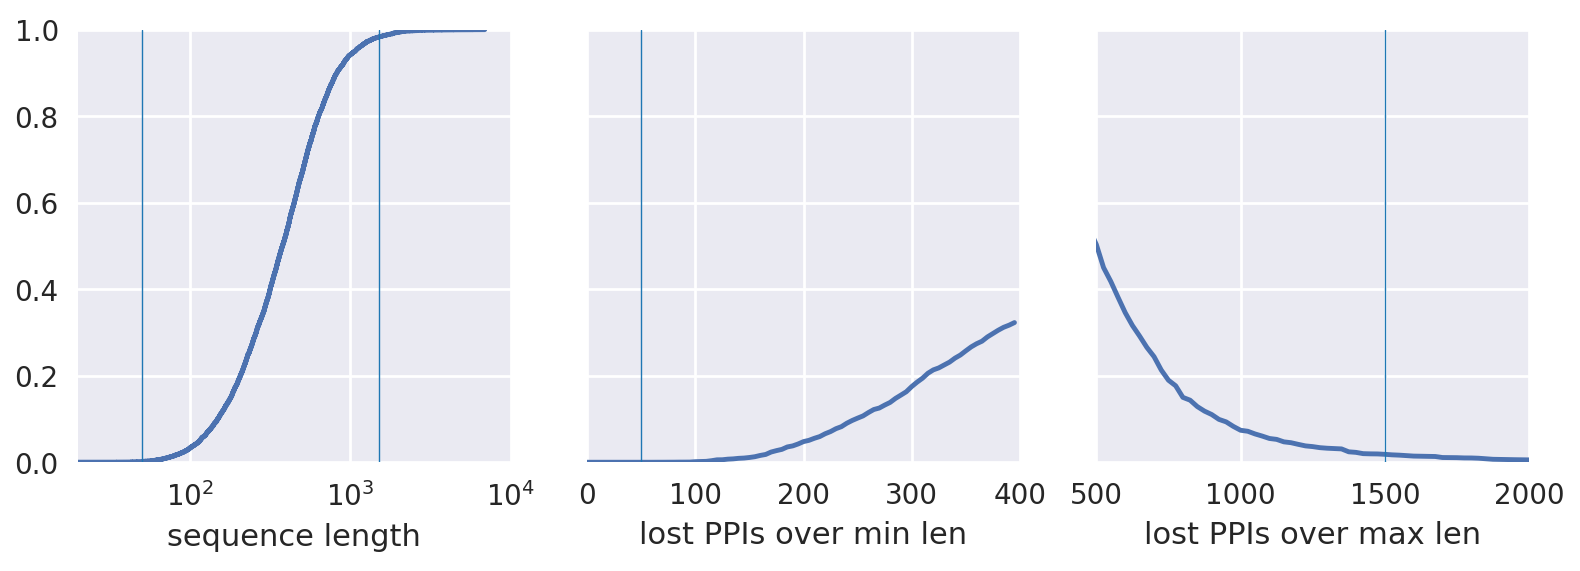

In [57]:
_huri_hash_ppis, _huri_seqs, fig = filter_ppis_and_fasta_by_len(
    huri_hash_ppis, huri_seqs, c.min_seq_len, c.max_seq_len)
len(huri_seqs), len(_huri_seqs)

#### test: save seqs + positives

In [58]:
huri_hash_ppis = _huri_hash_ppis
huri_seqs = _huri_seqs

In [59]:
_ = SeqIO.write(huri_seqs.values(), c.test_raw_fasta, 'fasta')
huri_hash_ppis.to_csv(c.test_raw_tsv, sep='\t', header=True, index=False)
c.test_raw_fasta, c.test_raw_tsv

(PosixPath('huri/huri_test_raw.fasta'), PosixPath('huri/huri_test_raw.tsv'))

## Test + validation: redundancy-reduce

Use [rostclust](https://git.rostlab.org/bernhoferm/mmseqs2-uniqueprot/-/tree/F_typer_app) to create non-redundant `test` and `validation` sets. <br> Don't run the next cells in the wrong order, and don't forget to copy the files back and forth if you are running `rostclust` elsewhere! <br>In particular, copy files after `shrink_files_both_ways`.

In [60]:
c.hval_config

{'shortAlignmentLen': 50,
 'longSeqLen': 180,
 'reduceRandomAlign': False,
 'clusterThreshold': 20}

The flag below allows me to test this notebook without the MMseqs2 runs. Leave `remote_rostclust` at `True` and copy the two result files to this folder; or run `rostclust uniqueprot[2D]` now and here.

In [ ]:
c.remote_rostclust

In [53]:
push()

In [ ]:
# redundancy-reduce the test set
run_uniqueprot(c.test_raw_fasta, c.test_rr_fasta, c.hval_config, pretend=c.remote_rostclust)

In [ ]:
# and validation
run_uniqueprot(c.val_raw_fasta, c.val_rr_fasta, c.hval_config, pretend=c.remote_rostclust)

In [57]:
pull()

In [62]:
fastalen = lambda _file: len([r.id for r in SeqIO.parse(_file, 'fasta')])

In [59]:
# also drop PPIs accordingly
assert c.test_rr_fasta.is_file()
shrink_files_both_ways(c.test_raw_tsv, c.test_rr_fasta,
                       new_tsv_name=c.test_rr_tsv)
c.test_seqs = fastalen(c.test_rr_fasta)
assert c.val_rr_fasta.is_file()
shrink_files_both_ways(c.val_raw_tsv, c.val_rr_fasta,
                       new_tsv_name=c.val_rr_tsv)
c.val_seqs = fastalen(c.val_rr_fasta)

dropped 2864/8773 table IDs and 36101/59251 rows, and 771/5909 sequence IDs
dropped 364/1197 table IDs and 634/1151 rows, and 191/833 sequence IDs


In [60]:
push()

## Prepare proteomes

In [63]:
if not c.add_proteomes:
    raise NotImplementedError('Please manually skip ahead!')

#### run separately: faster
Separately clustering the proteomes against the test/validation set and then redundancy-reducing each one is faster and might lead to a more balanced combined proteome set that is better fit to sample from than merging all proteomes first and then running the two steps on huge files.

#### train: cluster against val
Mind that `train_species` and `val_species` may overlap! We deal with that later.

In [ ]:
rr_pattern_proteomes(c.train_species,
                     proteome_dir=c.pp, pattern='{sp}.fasta', prefix='val',
                     ref_fasta=c.val_rr_fasta,
                     hval_config=hval_config, pretend=c.remote_rostclust)

#### train: cluster against test

In [ ]:
rr_pattern_proteomes(c.train_species,
                     proteome_dir=c.pp, pattern='{sp}_nr_val.fasta',
                     prefix='valtest', ref_fasta=c.test_rr_fasta,
                     hval_config=hval_config, pretend=c.remote_rostclust)

In [ ]:
pull()

These `_nr_valtest.fasta` proteomes are now ready to be used as negatives for the train set!

#### val: cluster against val

In [ ]:
rr_pattern_proteomes(c.val_species, c.pp, '{sp}.fasta', 'val',
                     ref_fasta=c.val_rr_fasta,
                     hval_config=hval_config, pretend=c.remote_rostclust)

#### val: redundancy-reduce

In [ ]:
rr_pattern_proteomes(c.val_species, c.pp, '{sp}_nr_val.fasta', 'val',
                     hval_config=hval_config, pretend=c.remote_rostclust)

#### val: merge

In [ ]:
pull()

In [70]:
val_concat = c.pp / 'val_proteome_concat.fasta'
merge_pattern_proteomes(c.val_species, val_concat, c.pp, '{sp}_rr_val.fasta')

In [ ]:
push()

#### val: redundancy-reduce merged set

In [71]:
val_concat_rr = val_concat.with_stem(val_concat.stem + '_rr')
run_uniqueprot(val_concat, val_concat_rr, hval_config, c.remote_rostclust)

'rostclust uniqueprot --hval-config-path hval_config.json swissprot/val_proteome_concat.fasta swissprot/val_proteome_concat_rr.fasta'

#### test: cluster against test

In [ ]:
run_uniqueprot2D(c.pp / '9606.fasta', c.test_rr_fasta, c.pp / '9606_nr_test.fasta',
                 hval_config=hval_config, pretend=c.remote_rostclust)

#### test: redundancy-reduce

In [ ]:
run_uniqueprot(c.pp / '9606_nr_test.fasta', c.pp / '9606_rr_test.fasta',
               hval_config=hval_config, pretend=c.remote_rostclust)

The `swissprot/9606_rr_test.fasta` can be used as test set negatives directly; as this is a single-species set there is no combined set that needs redundancy reduction.

#### collate train/val/test proteomes
Create per-species dicts of potential negative interaction partners. Doing this once to save some `pull` calls.

In [ ]:
pull()

In [86]:
train_proteome = read_hash_proteomes(c.train_species, c.pp, '{sp}_nr_valtest.fasta')
with c.train_proteome.open('w') as json_file:
    json.dump(train_proteome, json_file, indent=2)

100%|██████████| 20/20 [00:33<00:00,  1.69s/it, batch=2.7e+6] 


In [ ]:
val_proteome = parse_val_proteome(val_concat_rr)
with c.val_proteome.open('w') as json_file:
    json.dump(val_proteome, json_file, indent=2)

In [75]:
test_proteome = read_hash_proteomes({9606}, c.pp, '{sp}_rr_test.fasta')
with c.test_proteome.open('w') as json_file:
    json.dump(test_proteome, json_file, indent=2)

100%|██████████| 1/1 [00:01<00:00,  1.63s/it, batch=9606]


In [77]:
push()

## Generate negatives: examples
Negatives are sampled *per species*. Mind that the test set is human-only!
Start with the train set!
Re-write with proteomes, but without C123 labels.

In [61]:
c.ratio, c.seed, c.strategy

(10.0, 42, <SamplingStrategy.BALANCED: 1>)

In [62]:
train_proteome = {int(k): v for k, v in json.load(c.train_proteome.open('r')).items()}

In [85]:
train.head()

,hash_A,hash_B,species,minlen,maxlen,label
3,CRC-48F409F4E28F37BE,CRC-9AC87796A0BA67D9,632,170,833,1
1,CRC-4A7DEB955583CB27,CRC-6D6C1B4ED5C94EC7,632,266,334,1
0,CRC-5E21543540EBF92B,CRC-8561A9A0C1A2E169,632,95,326,1
2,CRC-8049DCC1A80C7391,CRC-9AC87796A0BA67D9,632,170,258,1
5,CRC-BED64D5961AA5E38,CRC-D4C3706260D2937A,632,207,780,1


In [86]:
train.species.value_counts()

3702       42794
7227       31832
559292     25498
6239       13694
192222     10863
10090       4186
284812      3302
243276      3294
1111708     2944
83333       2707
85962       2068
224308      1247
36329       1156
237561        26
10299         10
632            5
9986           3
2697049        3
1392           2
333760         1
Name: species, dtype: int64

#### tiny examples

10299: 10 positives, aim for 100 negatives


10299: 234it [00:00, 11153.92it/s]            

10299: 83/100 in-network negatives
10299: need 18 extra proteines; select 18 from 55/71 (new/available) SwissProt proteins. Try to create 34 interactions, ideally 10.0 per protein.
10299: got 117 negatives with bias 0.996


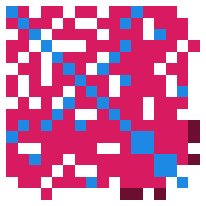

In [433]:
with mpl.rc_context({'figure.dpi': 64}):
    _ = make_negatives(
        train.loc[train.species == 10299].copy(),
        strategy=c.strategy.value, ratio=c.ratio, seed=c.seed,
        accept_homodimers=c.accept_homodimers, proteome=train_proteome)

237561: 26 positives, aim for 260 negatives


237561: 550it [00:00, 9784.23it/s]             

237561: 245/260 in-network negatives
237561: need 19 extra proteines; select 19 from 5138/5164 (new/available) SwissProt proteins. Try to create 30 interactions, ideally 10.0 per protein.
237561: got 275 negatives with bias 0.997


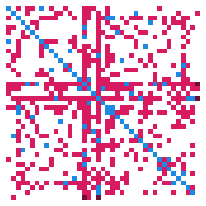

In [87]:
with mpl.rc_context({'figure.dpi': 64}):
    t_ppis, t_negs, t_bias, _ = make_negatives(
        train.loc[train.species == 237561].copy(),
        strategy=c.strategy.value, ratio=c.ratio, seed=c.seed,
        accept_homodimers=c.accept_homodimers, proteome=train_proteome)

In this symmectric adjacency matrix, true PPIs and interactions that are not allowed as negatives are shown in blue. This often includes the diagonal; homodimers. Selected negatives are in red. The last row/column indicates *wanted* interactions that could not be satisfied in the existing set; with darker/lighter red indicating more than one extra interaction for the protein in that row/column. These extra negative interaction partners were drawn from SwissProt proteomes.

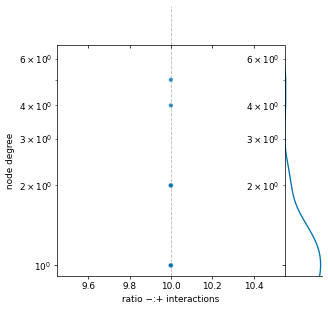

In [88]:
with mpl.rc_context({'figure.dpi': 64}):
    _ = plot_ratio_degree(t_ppis, t_negs, c.ratio)

#### small example

224308: 1247 positives, aim for 12470 negatives


224308: 29772it [00:04, 6186.46it/s]                           


224308: 10054/12470 in-network negatives
224308: need 1830 extra proteines; select 1830 from 3449/4012 (new/available) SwissProt proteins. Try to create 4832 interactions, ideally 10.0 per protein.
224308: got 14886 negatives with bias 1.000


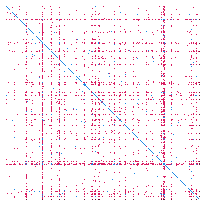

In [89]:
with mpl.rc_context({'figure.dpi': 64}):
    t_ppis, t_negs, _, _ = make_negatives(
        train.loc[train.species == 224308].copy(),
        strategy=c.strategy.value, ratio=c.ratio, seed=c.seed,
        accept_homodimers=c.accept_homodimers, proteome=train_proteome)

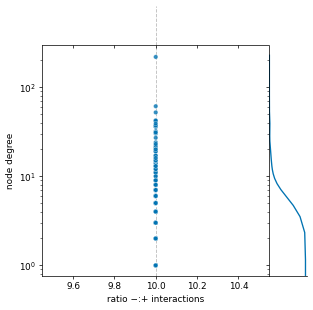

In [90]:
with mpl.rc_context({'figure.dpi': 64}):
    _, df = plot_ratio_degree(t_ppis, t_negs, c.ratio)

#### multi-species example

In [91]:
taxonomy.loc[taxonomy.species.isin(train.species)].sort_values(by='n_ppis')

,species,name,n_ppis
26,333760,Human papillomavirus type 16,2
1,1392,Bacillus anthracis,4
0,632,Yersinia pestis,6
9,9986,Oryctolagus cuniculus,10
30,2697049,Severe acute respiratory syndrome coronavirus 2,14
12,10299,Human alphaherpesvirus 1 strain 17,16
22,237561,Candida albicans SC5314,44
21,224308,Bacillus subtilis subsp. subtilis str. 168,1388
19,85962,Helicobacter pylori 26695,2305
15,36329,Plasmodium falciparum 3D7,2728


In [92]:
with mpl.rc_context({'figure.dpi': 64}):
    t_ppis, t_negs, _, _ = make_negatives(
        train.loc[train.species.isin({237561, 224308, 85962, 36329, 83333})].copy(),
        strategy=c.strategy.value, ratio=c.ratio, seed=c.seed,
        accept_homodimers=c.accept_homodimers, proteome=train_proteome)

sampling negatives per species! aim for 72040


237561: 552it [00:00, 8034.73it/s]             , 4792.29it/s]
36329: 23136it [00:05, 4614.07it/s]                           ]
224308: 29822it [00:05, 5001.22it/s][00:05<00:09, 3711.41it/s] 
85962: 41546it [00:09, 4272.45it/s]                           
83333: 54168it [00:15, 3445.82it/s]                           


74612 negatives with overall 1.000 and average per-species bias of 0.999±0.001 (std)


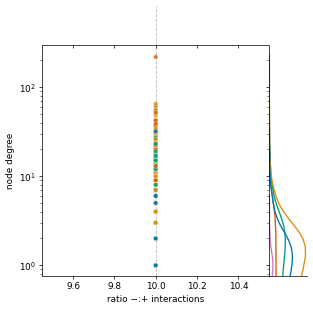

In [93]:
with mpl.rc_context({'figure.dpi': 64}):
    _ = plot_ratio_degree(t_ppis, t_negs, c.ratio)

#### tests from APID train

192222: 10863 positives, aim for 108630 negatives


192222: 241892it [01:02, 3857.72it/s]                            


192222: 96314/108630 in-network negatives
192222: need 1097 extra proteines; select 317 from 317/1549 (new/available) SwissProt proteins. Try to create 24632 interactions, ideally 10.0 per protein.
192222: got 117298 negatives with bias 0.985


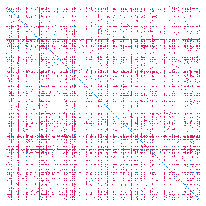

In [346]:
with mpl.rc_context({'figure.dpi': 64}):
    t_ppis, t_negs, *_ = make_negatives(
        train.loc[train.species == 192222].copy(),
        strategy=c.strategy.value, ratio=c.ratio, seed=c.seed,
        accept_homodimers=c.accept_homodimers, proteome=train_proteome)

243276: 3294 positives, aim for 32940 negatives


243276: 82224it [00:14, 5858.05it/s]                           


243276: 24768/32940 in-network negatives
243276: need 2358 extra proteines; select 298 from 298/958 (new/available) SwissProt proteins. Try to create 16344 interactions, ideally 10.0 per protein.
243276: got 33337 negatives with bias 0.899


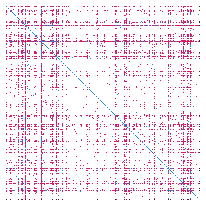

In [419]:
with mpl.rc_context({'figure.dpi': 64}):
    _ = make_negatives(
        train.loc[train.species == 243276].copy(),
        strategy=c.strategy.value, ratio=c.ratio, seed=c.seed,
        accept_homodimers=c.accept_homodimers, proteome=train_proteome)

2697049: 3 positives, aim for 30 negatives


2697049: 114it [00:00, 7688.17it/s]            

2697049: 3/30 in-network negatives
2697049: need 30 extra proteines; select 7 from 7/11 (new/available) SwissProt proteins. Try to create 54 interactions, ideally 10.0 per protein.
2697049: got 31 negatives with bias 0.650


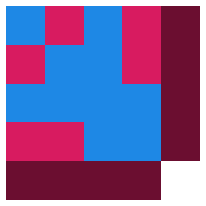

In [420]:
with mpl.rc_context({'figure.dpi': 64}):
    _ = make_negatives(
        train.loc[train.species == 2697049].copy(),
        strategy=c.strategy.value, ratio=c.ratio, seed=c.seed,
        accept_homodimers=c.accept_homodimers, proteome=train_proteome)

In this example, the number of available negatives falls far short of the target. The adjacency matrix is completely filled; and each protein would *should* get more than one extra negative interaction partner. However, we see that only 7 proteins in the non-redundant SwissProt proteome for this species were not already in the given set of PPIs, and we would actually need 30 to generate negatives at the target ratio.

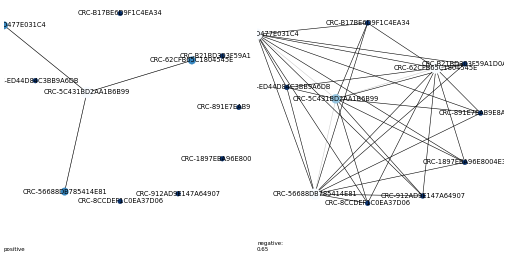

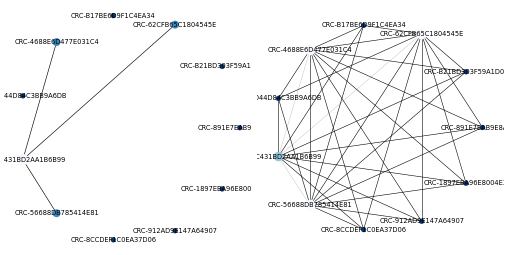

In [390]:
with mpl.rc_context({'figure.dpi': 40}):
    _ = draw_toy_ppis(t_ppis, dict(positive=t_ppis, negative=t_negs),
                      extra_nodes=set(np.unique(t_negs.iloc[:, [0, 1]])))

333760: 1 positives, aim for 10 negatives


333760: 40it [00:00, 5787.44it/s]             

333760: 0/10 in-network negatives
333760: need 10 extra proteines; select 7 from 7/9 (new/available) SwissProt proteins. Try to create 20 interactions, ideally 10.0 per protein.
333760: got 14 negatives with bias 1.000


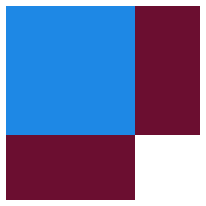

In [421]:
with mpl.rc_context({'figure.dpi': 64}):
    t_ppis, t_negs, *_ = make_negatives(
        train.loc[train.species == 333760].copy(),
        strategy=c.strategy.value, ratio=c.ratio, seed=c.seed,
        accept_homodimers=c.accept_homodimers, proteome=train_proteome)

/home/quirin/.local/lib/python3.10/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


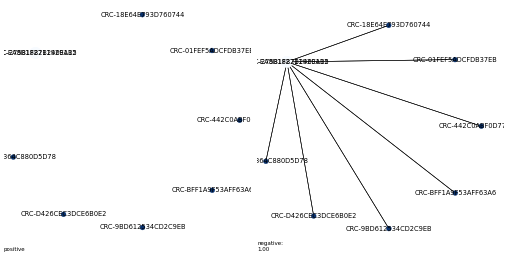

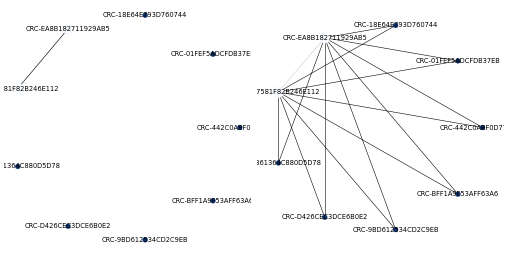

In [403]:
with mpl.rc_context({'figure.dpi': 40}):
    _ = draw_toy_ppis(t_ppis, dict(positive=t_ppis, negative=t_negs),
                      extra_nodes=set(np.unique(t_negs.iloc[:, [0, 1]])))

#### Find a faster algorithm

In [402]:
importlib.reload(api)
importlib.reload(extract)
importlib.reload(general)
importlib.reload(pairs)
importlib.reload(plot)
importlib.reload(reduce)
importlib.reload(proteome)

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *
from data.utils.proteome import *

In [743]:
true_ppis = train.loc[train.species == 224308].copy()
strategy = c.strategy.value
ratio = 11
sus_ppis = None
seed = c.seed
accept_homodimers = False  # c.accept_homodimers
proteome = train_proteome

In [744]:
# map protein IDs to their sorting index
uniq_true = {_id: idx for idx, _id in enumerate(
    np.unique(true_ppis.iloc[:, [0, 1]]))}
uniq_neg = {idx: _id for _id, idx in uniq_true.items()}
indexize = np.vectorize(uniq_true.get)
unindex = np.vectorize(uniq_neg.get)
idx_ppis = indexize(true_ppis.iloc[:, [0, 1]])

if sus_ppis is not None:
    idx_ppis = np.vstack((idx_ppis, indexize(sus_ppis.iloc[:, [0, 1]])))

# np.unique returns sorted values, so this works out
proteins, counts = np.unique(true_ppis.iloc[:, [0, 1]], return_counts=True)
n = len(proteins)
vertices = np.array(range(n))
indices = np.array(range(n + 1))

rng = np.random.default_rng(seed=seed)

wants = np.floor(counts * ratio / 2).astype(int)
if strategy != 1:
    wants = np.full_like(wants, np.floor(sum(counts) * ratio / 2 / n)).astype(int)

# make sure that wants is an integer vector and its sum as close to the target as possible
print(f'n: {n}')
idcs = list(rng.choice(vertices, size=n, replace=True, p=counts / sum(counts)))
while np.round(sum(counts) * ratio / 2) > sum(wants):
    idx = idcs.pop(0)
    wants[idx] += 1

wants[12] = max(64, wants[12])

limit = sum(wants)
limit, len(idx_ppis) * ratio

n: 40


(345, 286)

In [745]:
# initialize the matrix
mat = np.zeros((n, n), dtype=int)
if not accept_homodimers:
    np.fill_diagonal(mat, 1)
    # mat[-1, -1] = 0
mat[idx_ppis[:, 0], idx_ppis[:, 1]] = 1
mat[idx_ppis[:, 1], idx_ppis[:, 0]] = 1

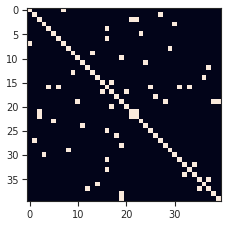

In [746]:
with mpl.rc_context({'figure.dpi': 64}):
    plt.imshow(mat)

In [747]:
np.count_nonzero(mat > 0)

92

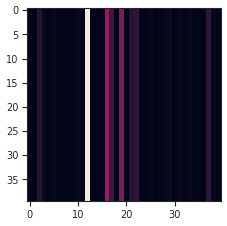

In [748]:
with mpl.rc_context({'figure.dpi': 64}):
    stripes = np.vstack(n * [wants])
    plt.imshow(stripes)

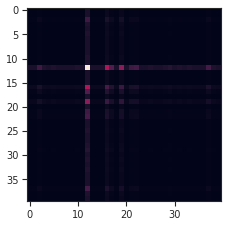

In [749]:
with mpl.rc_context({'figure.dpi': 64}):
    dot = wants.reshape(-1, 1) @ wants.reshape(1, -1)
    plt.imshow(dot)

In [750]:
np.count_nonzero(dot > 0), dot.shape

(1600, (40, 40))

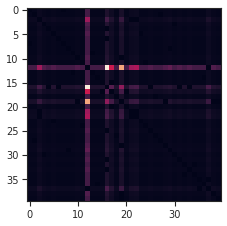

In [751]:
with mpl.rc_context({'figure.dpi': 64}):
    cross = wants.reshape(-1, 1) @ wants.reshape(1, -1)
    cross[np.nonzero(mat)] = 0
    plt.imshow(cross / np.sum(cross))

In [752]:
np.count_nonzero(cross == 0)

92

In [753]:
extras = np.clip(wants - np.count_nonzero(cross > 0, axis=0),
                 a_min=0, a_max=None)
extras

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 26,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])

In [754]:
extras / wants  # is the total share of the extras per column

array([0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.40625, 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     ])

In [755]:
xcs = np.max(extras)
xcs

26

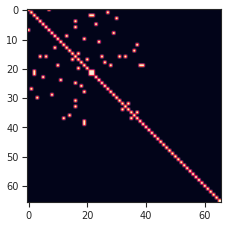

In [756]:
# initialize the matrix
mxs = np.zeros((n + xcs, n + xcs), dtype=int)
if not accept_homodimers:
    np.fill_diagonal(mxs, 1)
np.fill_diagonal(mxs[n:, n:], 1)  # do this anyway!
mxs[idx_ppis[:, 0], idx_ppis[:, 1]] = 1
mxs[idx_ppis[:, 1], idx_ppis[:, 0]] = 1
with mpl.rc_context({'figure.dpi': 64}):
    plt.imshow(mxs)

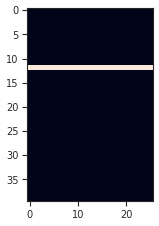

In [757]:
attach = np.zeros((n, xcs), dtype=int)
for i, e in enumerate(extras):
    attach[i, :e] = 1
with mpl.rc_context({'figure.dpi': 64}):
    plt.imshow(attach)

In [758]:
np.sum(attach, axis=0)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [759]:
wints = np.append(wants, np.sum(attach, axis=0))

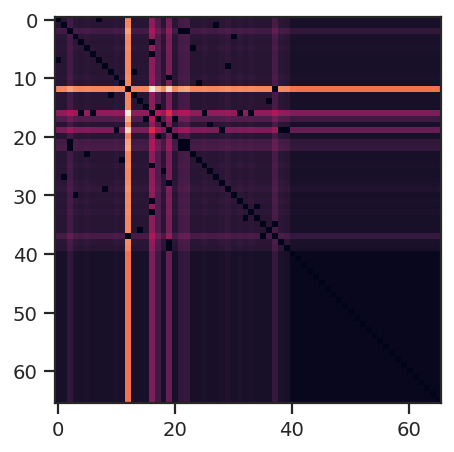

In [773]:
with mpl.rc_context({'figure.dpi': 128}):
    # cross = wints.reshape(-1, 1) @ wints.reshape(1, -1)
    cross = np.vstack((n + xcs) * [wints]) + np.vstack((n + xcs) * [wints]).T
    cross[np.nonzero(mxs)] = 0
    plt.imshow(cross)

In [774]:
np.sum(extras), np.sum(wants), np.sum(cross), np.sum(cross) / np.sum(wants)

(26, 345, 47058, 136.4)

In [776]:
cross

array([[ 0, 10, 16, ...,  6,  6,  6],
       [10,  0, 16, ...,  6,  6,  6],
       [16, 16,  0, ..., 12, 12, 12],
       ...,
       [ 6,  6, 12, ...,  0,  2,  2],
       [ 6,  6, 12, ...,  2,  0,  2],
       [ 6,  6, 12, ...,  2,  2,  0]])

In [777]:
np.sqrt(np.sum(cross))

216.92855966884582

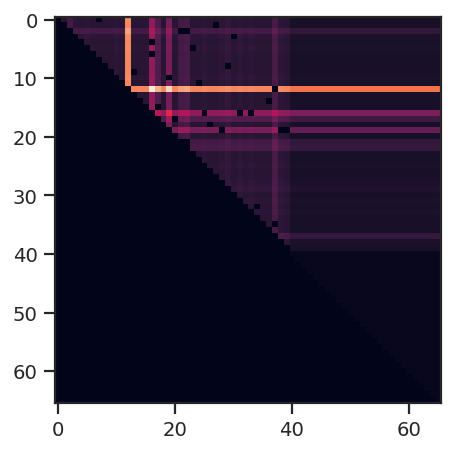

In [778]:
# once you're at that point, only draw from the triu to avoid the symmetry mess
with mpl.rc_context({'figure.dpi': 128}):
    # cross = wints.reshape(-1, 1) @ wints.reshape(1, -1)
    cross = np.vstack((n + xcs) * [wints]) + np.vstack((n + xcs) * [wints]).T
    cross[np.nonzero(mat)] = 0
    tri = np.triu(cross)
    plt.imshow(tri / np.sum(tri))

In [779]:
np.count_nonzero(tri > 0), np.count_nonzero(tri == 0)

(2145, 2211)

In [780]:
tri.ravel()

array([ 0, 10, 16, ...,  0,  0,  2])

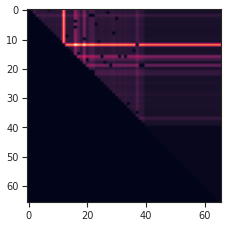

In [781]:
# un-raveling is easy
with mpl.rc_context({'figure.dpi': 64}):
    plt.imshow(tri.ravel().reshape(n + xcs, n + xcs))

In [782]:
idcs = rng.choice(np.arange(len(tri.ravel())),
                  size=limit, replace=False, p=tri.ravel() / np.sum(tri))
idcs.sort()

In [783]:
t_negs = np.zeros_like(tri)
t_negs.ravel()[idcs] = -1

In [ ]:
# un-raveling is easy
with mpl.rc_context({'figure.dpi': 300}):
    plt.imshow(t_negs)
    # plt.imshow(tri)

In [423]:
train.loc[train.species == 237561]

,hash_A,hash_B,species,minlen,maxlen,label
18,CRC-063BD314C9755686,CRC-562BA08EDDFE2EFD,237561,645,656,1
13,CRC-230A832F5FF95210,CRC-BB03BB1B0CE9547E,237561,106,111,1
2,CRC-3F7DA56CCBAABA1F,CRC-89E4EDDEBF322868,237561,508,589,1
3,CRC-3F7DA56CCBAABA1F,CRC-8D0006B955C239FB,237561,589,745,1
11,CRC-4A824993A13ECBF9,CRC-C968DD3E0BB365BC,237561,340,701,1
10,CRC-51C7E74B0AD30AAB,CRC-777B4535B22EA81F,237561,298,550,1
25,CRC-55DAF24C27F4CA0A,CRC-9D8A0EE7F2DECBC0,237561,188,745,1
16,CRC-561544C4119C4D6C,CRC-777B4535B22EA81F,237561,385,550,1
36,CRC-58A264075A9E2C4C,CRC-BDDDF466F06F9323,237561,507,785,1
5,CRC-5EDFBB9B834E3478,CRC-6E549EBCD33F0184,237561,886,1152,1


In [442]:
print(taxonomy.loc[taxonomy.species.isin({10299, 237561, 36329, 224308})].sort_values(by='n_ppis').to_markdown(index=False))

|   species | name                                       |   n_ppis |
|----------:|:-------------------------------------------|---------:|
|     10299 | Human alphaherpesvirus 1 strain 17         |       16 |
|    237561 | Candida albicans SC5314                    |       44 |
|    224308 | Bacillus subtilis subsp. subtilis str. 168 |     1388 |
|     36329 | Plasmodium falciparum 3D7                  |     2728 |


In [447]:
train.groupby('species')['label'].count()

species
632            5
1392           2
3702       42794
6239       13694
7227       31832
9986           3
10090       4186
10299         10
36329       1156
83333       2707
85962       2068
192222     10863
224308      1247
237561        26
243276      3294
284812      3302
333760         1
559292     25498
1111708     2944
2697049        3
Name: label, dtype: int64

## APID train
#### generate negatives

In [404]:
# sanity check if there are any proteins in test that
# were already in train. re: "do not add back in identical ones"
assert not ({r.id for r in SeqIO.parse(c.train_raw_fasta, 'fasta')} & {
    r.id for r in SeqIO.parse(c.test_rr_fasta, 'fasta')})

In [132]:
train_ppis, train_negs, train_bias, _ = make_negatives(
    train, strategy=c.strategy.value, ratio=c.ratio, seed=c.seed,
    accept_homodimers=c.accept_homodimers, proteome=train_proteome)

sampling negatives per species! aim for 1456350


632: 138it [00:00, 4471.75it/s]             
1392: 72it [00:00, 4577.96it/s]             
9986: 96it [00:00, 4220.20it/s]             t/s]
10299: 234it [00:00, 2194.12it/s]             s]778.94it/s]
237561: 552it [00:00, 1601.00it/s]                         /s]
2697049: 114it [00:00, 715.15it/s]              1600.83it/s]]]
333760: 40it [00:00, 260.47it/s]              , 1316.43it/s]  
559292:   0%|          | 70/509960 [00:00<12:26, 683.14it/s]]

333760: 0/10 in-network negatives


36329: 23136it [00:17, 1304.57it/s]                           s]
224308: 29822it [00:21, 1374.03it/s]0 [00:21<02:14, 1450.50it/s]
85962: 41546it [00:32, 1295.90it/s] [00:32<00:18, 1169.10it/s]]]
243276: 82330it [00:49, 1653.23it/s]0 [00:49<00:06, 1331.81it/s]
83333: 54168it [00:51, 1055.85it/s]                           s]
1111708: 58882it [00:56, 1051.12it/s]                           
284812: 69498it [01:03, 1100.37it/s][01:03<19:16, 532.13it/s]/s]
10090: 84438it [01:29, 938.99it/s]  [01:30<04:02, 898.34it/s]t/s]
192222: 241908it [02:01, 1983.88it/s]02:01<16:40, 578.11it/s]s]  
6239: 275254it [04:51, 944.78it/s] 960 [04:50<03:32, 1167.34it/s]
559292: 512904it [08:30, 1005.57it/s][08:30<08:14, 583.64it/s]   
7227: 636696it [14:42, 721.11it/s]                             
3702: 866296it [19:57, 723.40it/s]                             


1476474 negatives with overall 0.994 and average per-species bias of 0.974±0.078 (std)


1476474 negatives with overall 0.994 and average per-species bias of 0.974±0.078 (std)

#### bias

In [416]:
c.train_bias = train_bias.set_index('species').to_dict()['bias']
train_bias.sort_values(by='bias')

NameError: name 'train_bias' is not defined

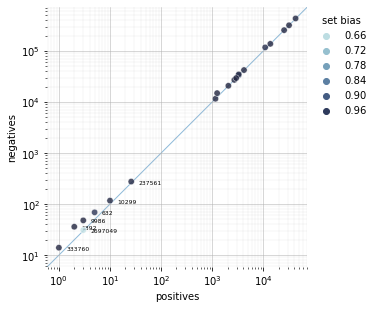

In [342]:
with mpl.rc_context({'figure.dpi': 72}):
    _ = plot_bias(train_ppis, train_negs, train_bias, c.ratio)
    # fig.savefig('train_bias.png', transparent=False)

#### degrees
Evaluate how close the real ratio of negative : positive interactions per protein is to our target ratio

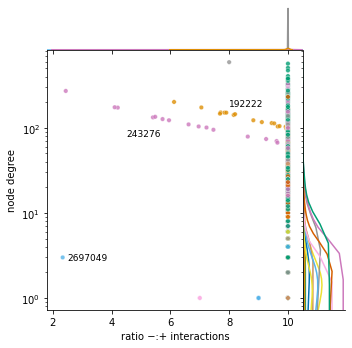

In [343]:
with mpl.rc_context({'figure.dpi': 72}):
    fig, df = plot_ratio_degree(train_ppis, train_negs, c.ratio)
    ax = fig.axes[0]
    ax.set(xlim=(1.8, 10.5))
    ax.annotate(2697049, xy=(2.5, 2.8), size=9)
    ax.annotate(243276, xy=(4.5, 80), size=9)
    ax.annotate(192222, xy=(8, 180), size=9)
    # fig.savefig('train_ratio_degree.png', transparent=False)

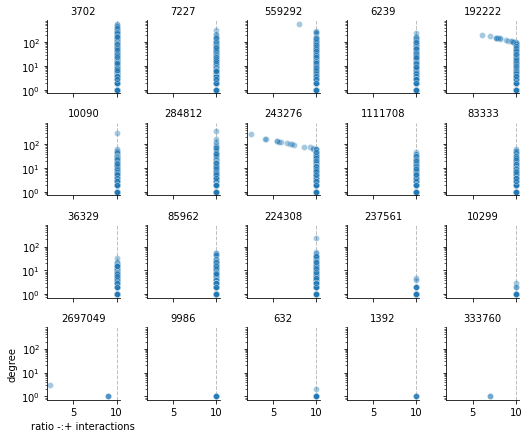

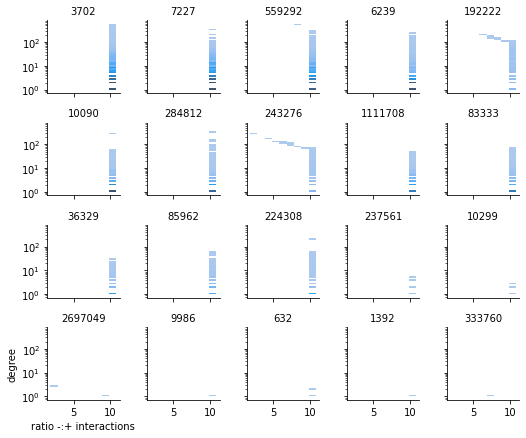

In [430]:
order = (taxonomy.loc[taxonomy.species.isin(train.species)]
             .sort_values(by='n_ppis')['species'][::-1])
with mpl.rc_context({'figure.dpi': 72}):
    g, h = plot_ratio_grids(df, order, c.ratio)

In [409]:
desc = (df  #.loc[df.degree <= 3]
        .groupby('species')
        .describe()
        ['ratio']
        .sort_values(by='count')
        .round(2)
        .convert_dtypes()
        )
desc

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
333760,2,7.0,0.0,7.0,7.0,7,7,7
2697049,4,7.33,3.33,2.33,7.33,9,9,9
1392,4,10.0,0.0,10.0,10.0,10,10,10
9986,6,10.0,0.0,10.0,10.0,10,10,10
632,9,10.0,0.0,10.0,10.0,10,10,10
10299,16,10.0,0.0,10.0,10.0,10,10,10
237561,40,10.0,0.0,10.0,10.0,10,10,10
224308,603,10.0,0.0,10.0,10.0,10,10,10
243276,684,9.93,0.59,2.44,10.0,10,10,10


#### save
The PPIs are easy:

In [432]:
train_all = pd.concat((train_ppis, train_negs))
train_all.to_csv(c.train_tsv, sep='\t', header=True, index=False)
c.train_size = len(train_all)
c.train_size, c.train_tsv

(1622109, PosixPath('apid_train.tsv'))

But update the set of sequences with the added SwissProt proteins.

In [433]:
assert not set(np.unique(train_ppis.iloc[:, [0, 1]])) - train_seqs.keys()

In [434]:
train_extra = get_proteome_seqs(train_proteome, train_seqs, train_negs)
_ = SeqIO.write(values_sorted_by_key(train_extra),
                c.pp / 'train_extra.fasta', 'fasta')
train_seqs.update(train_extra)
c.train_extra = len(train_extra)
c.train_extra

In [435]:
_ = SeqIO.write(values_sorted_by_key(train_seqs), c.train_fasta, 'fasta')
len(train_seqs), c.train_fasta

(48093, PosixPath('apid_train.fasta'))

In [436]:
assert len(train_all), len(train_seqs) == shrink_both_ways(
    train_all.copy(), train_seqs.copy())

## APID validation
#### generate negatives
The `val` DataFrame is not up-to-date, use the contents of `val_rr_tsv` and `val_rr_fasta` instead!

In [142]:
val = pd.read_csv(c.val_rr_tsv, sep='\t', header=0)
val_seqs = SeqIO.to_dict(SeqIO.parse(c.val_rr_fasta, 'fasta'))
len(val), len(val_seqs)

(517, 642)

In [143]:
set(val.species)

{7955, 8355, 9031, 9913, 10116, 10377, 37296, 39947}

In [144]:
val_proteome = {int(k): v for k, v in json.load(c.val_proteome.open('r')).items()}

In [145]:
val_ppis, val_negs, val_bias, _ = make_negatives(
    val, strategy=c.strategy.value, ratio=c.ratio, seed=c.seed,
    accept_homodimers=c.accept_homodimers, proteome=val_proteome)

sampling negatives per species! aim for 5170


7955: 616it [00:00, 6139.13it/s]             
8355: 316it [00:00, 3168.83it/s]             ]]
9031: 374it [00:00, 3636.85it/s]             
10377: 232it [00:00, 5885.32it/s]             
37296: 1166it [00:00, 7849.89it/s]                        ]
9913: 1654it [00:00, 7005.39it/s]                          ]
39947: 1742it [00:00, 7586.61it/s]                          
10116: 5908it [00:00, 6933.79it/s]                          


5902 negatives with overall 0.996 and average per-species bias of 0.984±0.031 (std)


5902 negatives with overall 0.996 and average per-species bias of 0.984±0.031 (std)

#### bias

In [414]:
c.val_bias = val_bias.set_index('species').to_dict()['bias']

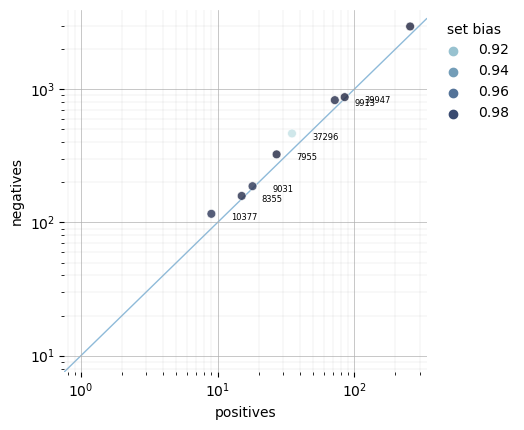

In [146]:
with mpl.rc_context({'figure.dpi': 100}):
    fig = plot_bias(val_ppis, val_negs, val_bias, c.ratio)
    fig.savefig('val_bias.png', transparent=False)

#### degrees

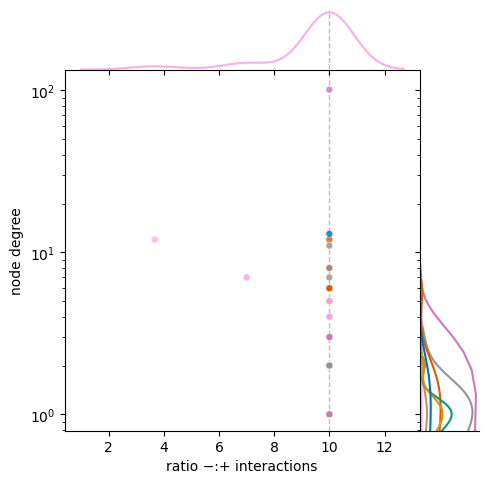

In [147]:
with mpl.rc_context({'figure.dpi': 100}):
    fig, vdf = plot_ratio_degree(val_ppis, val_negs, c.ratio)
    fig.savefig('val_ratio_degree.png', transparent=False)

Are we running out of extra proteins again?

In [148]:
vdf.loc[vdf.ratio != c.ratio]

,crc_hash,degree,ratio,species
200,CRC-468877D25B4B0173,7,7.000000,37296
500,CRC-C34E41D6B181DAFB,7,7.000000,37296
624,CRC-F8F5876EFDA2BB35,12,3.666667,37296


37296: 35 positives, aim for 350 negatives


37296: 1168it [00:00, 10923.15it/s]           

37296: 116/350 in-network negatives
37296: need 114 extra proteines; select 37 from 37/37 (new/available) SwissProt proteins. Try to create 468 interactions, ideally 10.0 per protein.
37296: got 463 negatives with bias 0.898


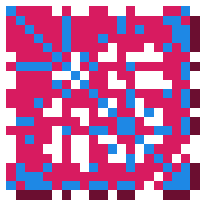

In [149]:
with mpl.rc_context({'figure.dpi': 64}):
    v_ppis, v_negs, v_bias, _ = make_negatives(
        val.loc[val.species == 37296].copy(),
        strategy=c.strategy.value, ratio=c.ratio, seed=c.seed,
        accept_homodimers=c.accept_homodimers, proteome=val_proteome)

Yes we are running out of extra (SwissProt) proteins again!

#### save
First, save the PPIs as a `TSV`. This is straightforward, but we will overwrite that file right after clustering the `FASTA`.

In [155]:
val_all = pd.concat((val_ppis, val_negs))
val_all.to_csv(c.val_tsv, sep='\t', header=True, index=False)
c.val_size = len(val_all)
c.val_size, c.val_tsv

(6419, PosixPath('apid_validation.tsv'))

In [156]:
assert not set(np.unique(val_ppis.iloc[:, [0, 1]])) - val_seqs.keys()

In [162]:
val_extra = get_proteome_seqs(val_proteome, val_seqs, val_negs)
_ = SeqIO.write(values_sorted_by_key(val_extra),
                c.pp / 'val_extra.fasta', 'fasta')
c.val_extra = len(val_extra)
c.val_extra, len(val_seqs)

(1055, 642)

In [164]:
val_seqs.update(val_extra)

In [168]:
_ = SeqIO.write(values_sorted_by_key(val_seqs), c.val_fasta, 'fasta')
len(val_seqs), c.val_fasta

(1697, PosixPath('apid_validation.fasta'))

In [167]:
assert len(val_all), len(val_seqs) == shrink_both_ways(
    val_all.copy(), val_seqs.copy())

#### cluster against train
Clustering the `APID` validation set against the `APID` train set gives us **C1-3** labels for the validation set.

In [ ]:
push()

In [219]:
run_uniqueprot2D(c.val_fasta, c.train_fasta, c.val_c3_fasta,
                 hval_config=c.hval_config, pretend=c.remote_rostclust)

'rostclust uniqueprot2d --hval-config-path hval_config.json apid_validation.fasta apid_train.fasta apid/apid_validation_c3.fasta'

In [ ]:
pull()

#### label PPIs

In [296]:
val_pairs = make_c_classes(c.val_tsv, c.val_c3_fasta, c.val_fasta)

#### class sizes

In [394]:
importlib.reload(api)
importlib.reload(extract)
importlib.reload(general)
importlib.reload(pairs)
importlib.reload(plot)
importlib.reload(reduce)
importlib.reload(proteome)

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *
from data.utils.proteome import *

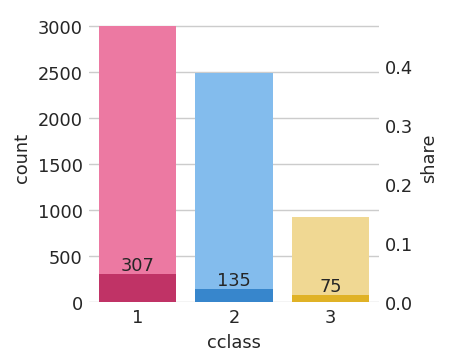

In [395]:
with mpl.rc_context({'figure.dpi': 128}):
    fig, c.val_sizes = plot_c_classes(val_pairs)
    fig.savefig('val_cclasses.png', transparent=False)

In [386]:
# sizes of the sets of positives per species
dict(val_ppis.species.value_counts())

{10116: 256,
 39947: 85,
 9913: 72,
 37296: 35,
 7955: 27,
 9031: 18,
 8355: 15,
 10377: 9}

#### save

In [377]:
if not (bak := c.val_tsv.with_suffix('.tsv.bak')).is_file():
    shutil.move(c.val_tsv, bak)
val_pairs.to_csv(c.val_tsv, sep='\t', header=True, index=False)
c.val_tsv

PosixPath('apid_validation.tsv')

## HuRI test
#### generate negatives
Read in the files first ...

In [210]:
test = pd.read_csv(c.test_rr_tsv, sep='\t', header=0)
test_seqs = SeqIO.to_dict(SeqIO.parse(c.test_rr_fasta, 'fasta'))
len(test), len(test_seqs)

(23150, 5138)

In [171]:
set(test.species)

{9606}

In [174]:
test_proteome = {int(k): v for k, v in json.load(c.test_proteome.open('r')).items()}
len(test_proteome[9606])

10360

9606: 23150 positives, aim for 231500 negatives


9606: 467152it [04:27, 1743.87it/s]                            


9606: 229424/231500 in-network negatives
9606: need 384 extra proteines; select 416 from 10358/10360 (new/available) SwissProt proteins. Try to create 4152 interactions, ideally 10.0 per protein.
9606: got 233576 negatives with bias 1.000


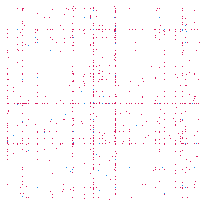

In [201]:
with mpl.rc_context({'figure.dpi': 64}):
    test_ppis, test_negatives, c.test_bias, _ = make_negatives(
        test, strategy=c.strategy.value, ratio=c.ratio, seed=c.seed,
        accept_homodimers=c.accept_homodimers, proteome=test_proteome)

In [202]:
test_ppis.head()

,hash_A,hash_B,species,label
0,CRC-450D36A80D6D88C8,CRC-8A19DDC376DCD0F4,9606,1
1,CRC-4CB899386D443FEA,CRC-9C54AFA126F17AF1,9606,1
2,CRC-1211E96DDC0A3182,CRC-B7F0D1D01ADFDFE7,9606,1
3,CRC-23F4C21E7327DE3D,CRC-8E2B9CB2B8FB72AD,9606,1
4,CRC-79AE0E5DF5488CA1,CRC-EA627A87958B83B6,9606,1


In [203]:
test_negatives.head()

,hash_A,hash_B,species,label
0,CRC-000037AE195F7A9D,CRC-0518B04A0E991529,9606,0
1,CRC-000037AE195F7A9D,CRC-1BC05EFF56344915,9606,0
2,CRC-000037AE195F7A9D,CRC-36572156BABDA876,9606,0
3,CRC-000037AE195F7A9D,CRC-5B917C1159B1B7E2,9606,0
4,CRC-000037AE195F7A9D,CRC-75BD22E490DC1467,9606,0


#### bias
As the test set contains only single species, this is just a number

In [399]:
c.test_bias

0.999878044690968

#### degrees

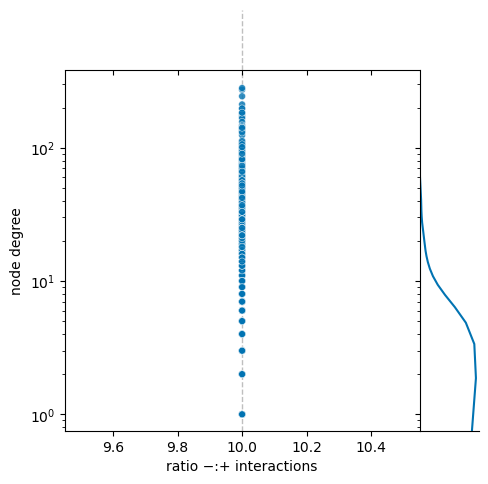

In [464]:
with mpl.rc_context({'figure.dpi': 100}):
    fig, tdf = plot_ratio_degree(test_ppis, test_negatives, c.ratio)
    fig.savefig('test_ratio_degree.png', transparent=False)

In [206]:
tdf.loc[tdf.ratio != c.ratio]

,crc_hash,degree,ratio,species


#### save
First, save the PPIs as a `TSV`. This is straightforward, but we will overwrite that file right after clustering the `FASTA`.

In [207]:
test_all = pd.concat((test_ppis, test_negatives))
test_all.to_csv(c.test_tsv, sep='\t', header=True, index=False)
c.test_size = len(test_all)
c.test_size, c.test_tsv

(256726, PosixPath('huri_test.tsv'))

In [208]:
assert not set(np.unique(test_ppis.iloc[:, [0, 1]])) - test_seqs.keys()

In [211]:
test_extra = get_proteome_seqs(test_proteome, test_seqs, test_negatives)
_ = SeqIO.write(values_sorted_by_key(test_extra),
                c.pp / 'test_extra.fasta', 'fasta')
c.test_extra = len(test_extra)
c.test_extra, len(test_seqs)

(416, 5138)

In [212]:
test_seqs.update(test_extra)

In [213]:
_ = SeqIO.write(values_sorted_by_key(test_seqs), c.test_fasta, 'fasta')
len(test_seqs), c.test_fasta

(5554, PosixPath('huri_test.fasta'))

In [214]:
assert len(test_all), len(test_seqs) == shrink_both_ways(
    test_all.copy(), test_seqs.copy())

#### cluster against train
Clustering the `HuRI` test set against the `APID` train set gives us **C1-3** labels for the test set.

In [216]:
push()

In [217]:
run_uniqueprot2D(c.test_fasta, c.train_fasta, c.test_c3_fasta,
                 hval_config=c.hval_config, pretend=c.remote_rostclust)

'rostclust uniqueprot2d --hval-config-path hval_config.json huri_test.fasta apid_train.fasta huri/huri_test_c3.fasta'

In [232]:
pull()

#### label PPIs

In [299]:
test_pairs = make_c_classes(c.test_tsv, c.test_c3_fasta, c.test_fasta)

#### class sizes

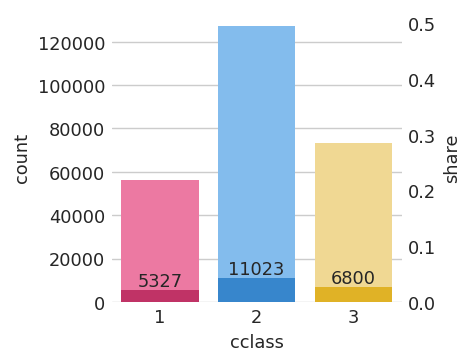

In [397]:
with mpl.rc_context({'figure.dpi': 128}):
    fig, c.test_sizes = plot_c_classes(test_pairs)
    fig.savefig('test_cclasses.png', transparent=False)

#### save

In [376]:
if not (bak := c.test_tsv.with_suffix('.tsv.bak')).is_file():
    shutil.move(c.test_tsv, bak)
test_pairs.to_csv(c.test_tsv, sep='\t', header=True, index=False)
c.test_tsv

PosixPath('huri_test.tsv')

DeprecationWarning: Proteins by themselves do not have a C123 class but are assigned one here! PPIs belong to a class.

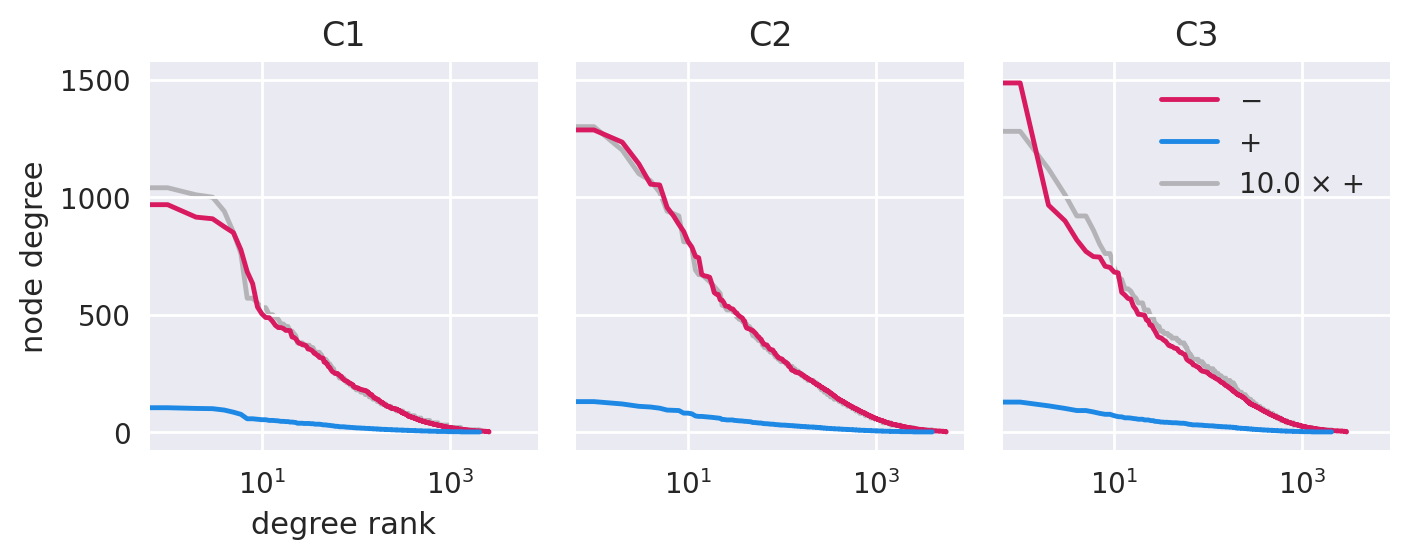

In [375]:
_ = plot_test_ratios(test_pairs, c.ratio)

---

In [415]:
with Path(f'cfg.json').open('w') as json_file:
    json_file.write(c.to_json(indent=2))
print(c.to_json(indent=2))

{
  "keep_human": false,
  "keep_interspecies": false,
  "accept_homodimers": false,
  "remote_rostclust": true,
  "add_proteomes": true,
  "ap": "apid",
  "hp": "huri",
  "qp": "apid_q1",
  "pp": "swissprot",
  "min_seq_len": 50,
  "max_seq_len": 1500,
  "hval_config": {
    "shortAlignmentLen": 50,
    "longSeqLen": 180,
    "reduceRandomAlign": false,
    "clusterThreshold": 20
  },
  "hval_config_path": "hval_config.json",
  "seed": 42,
  "ratio": 10.0,
  "strategy": 1,
  "val_set_size": 0.1,
  "val_species": [
    8355,
    10116,
    9031,
    10377,
    39947,
    37296,
    7955,
    9913
  ],
  "train_species": [
    9986,
    83333,
    284812,
    1111708,
    224308,
    10299,
    7227,
    559292,
    333760,
    85962,
    243276,
    2697049,
    192222,
    6239,
    36329,
    10090,
    1392,
    3702,
    632,
    237561
  ],
  "val_raw_fasta": "apid/apid_validation_raw.fasta",
  "val_raw_tsv": "apid/apid_validation_raw.tsv",
  "val_rr_fasta": "apid/apid_validation_